Welcome to the HDMM_NN Tutorial! For an overview of what HDDM is about, as well as installation instructions, 
visit the github page of this tutorial.

In [1]:
# TODO: PRERUN MCMC SAMPLING AND STORE TRACES IN DATA_STORAGE/TRACES/
# SO WE HAVE THE CHANCE TO FORGO SAMPLING

In [1]:
# Module imports
import hddm
import sys
import pandas as pd
import numpy as np
import sys
import pickle
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('simulators')
import cddm_data_simulation as cds
import boundary_functions as bf

from helper_functions import simulator
from helper_functions import model_plot
from helper_functions import caterpillar_plot
from helper_functions import posterior_pair_plot
from helper_functions import hddm_preprocess_hierarchical
from helper_functions import simulator_condition_effects
from helper_functions import make_parameter_sets
# posterior predictive plot
# caterpillar plot
from helper_functions import _make_trace_plotready_condition

from helper_functions import hddm_preprocess

/home/an/miniconda3/envs/hddm4/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


# Section 1: A look into DDM variations
Let's simulate some data from the angle model and check the resulting (choice, reaction) time data.
You can change the number of samples (n_samples), and the parameters of the model (v, a, w, ndt, theta). 
If you are outside of the valid range for any parameter you will be warned. First, let's begin with the angle model, in which the decision bound $a$ is a line making an angle $\theta$ with the $y$ axis.

## Angle model
In the angle model, we have 5 parameters:
- $a$, a boundary scalar. $a$ reflects how much relative evidence one would need to reach a certain choice. The higher $a$ is, the more evidence is needed in favor of one option over the other, before a choice is taken. An example of a way to expect higher $a$ value would be to tell the participant to 'be as prudent and accurate as possible'.
- $v$, drift, or evidence for/against a certain choice. Note that as a task becomes more difficult, $v$ could decrease.
- $w$, bias, accounts for an a priori preference towards a choice compared to the other (a reason for this might be an imbalance or otherwise detected pattern in the stimulus set
- $t$, non-decision time, which is basically a 'lag' before the participant knows what's going on.
- $\theta$, the angle parameter, that differentiates this model from regular DDM.

### make_parameter_sets (model, n_parameter_sets, param_dict)
Parameters:
- **model**: string, 'ddm', 'angle' or 'weibull_cdf'
- **n_parameter_sets**: integer, the number of parameter sets desired.
- **param_dict**: a dictionary containing any specific parameters. For example, `param_dict = {'v': [1]}` will make all the parameter sets have $v$ = 1. Can be used in combination with list comprehension and `np.linspace` to produce jumps. For example, `{'v' = [i for i in np.linspace(0.5, 1.5, 5)]}` causes $v$ to increase from 0.5 to 1.5 in 5 steps.

Returns:
A `pandas` frame consisting of the parameter sets. To access the $n$-th parameter set as an array, call `values[n]`.


In [ ]:
# TODO: put in exlanantion about angle model and what paraeters means. 

In [5]:
# LETS START WITH MAKING SOME PARAMETERS FOR OUR MODEL OF CHOICE
##make_parameter_sets:

angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 5,
                                   param_dict = {'v': [i for i in np.linspace(0.5, 1.5, 5)]})

In [6]:
angle_params.values[0]

array([0.5       , 1.49209757, 0.31909258, 1.48153367, 0.29039587])

### simulator(model, theta, n_samples)
Parameters:
- **model**: string, 'ddm', 'angle' or 'weibull_cdf'
- **theta**: an array in the output of `make_parameter_sets`. Automatically handles theta/alpha/beta in the case of angle/weibull models. 
- **n_samples**: integer.

Returns:
A 3-tupule of:
0. An array of time data
1. An array of choice data
2. Metadata

In [7]:
simulations = simulator(theta = angle_params.values[0],
                        model = 'angle', 
                        n_samples = 2000)

In [8]:
simulations[0]

array([[2.837541 ],
       [2.5595279],
       [2.772538 ],
       ...,
       [2.4775243],
       [1.7595336],
       [2.8615422]], dtype=float32)

Now that we have our simulated data, we look to visualise it.
## Plotting a sample dataset
### model_plot(ground_truths, posterior_samples, cols, model_gy, datatype, n_plots, max_t, show_model)

Parameters:

- **ground_truths**: arrays of ground truth parameters
- **posterior_samples**: posterior data. For now, leave this as `None` since we are only plotting our simulated data.
- **cols**: integer, number of columns of plots. Only relevant when plotting multiple plots.
- **n_plots**: integer, number of plots
- **model_gt**: string, 'ddm', 'angle' or 'weibull_cdf'. The model from which the ground truth data came from.
- **datatype**: string, 'single_subject', 'hierarchical' or 'condition'
- **max_t**: float, maximum reaction time shown
- **show_model**: bool, whether or not the parameter lines are shown

Return:

Plot of the appropriate information.

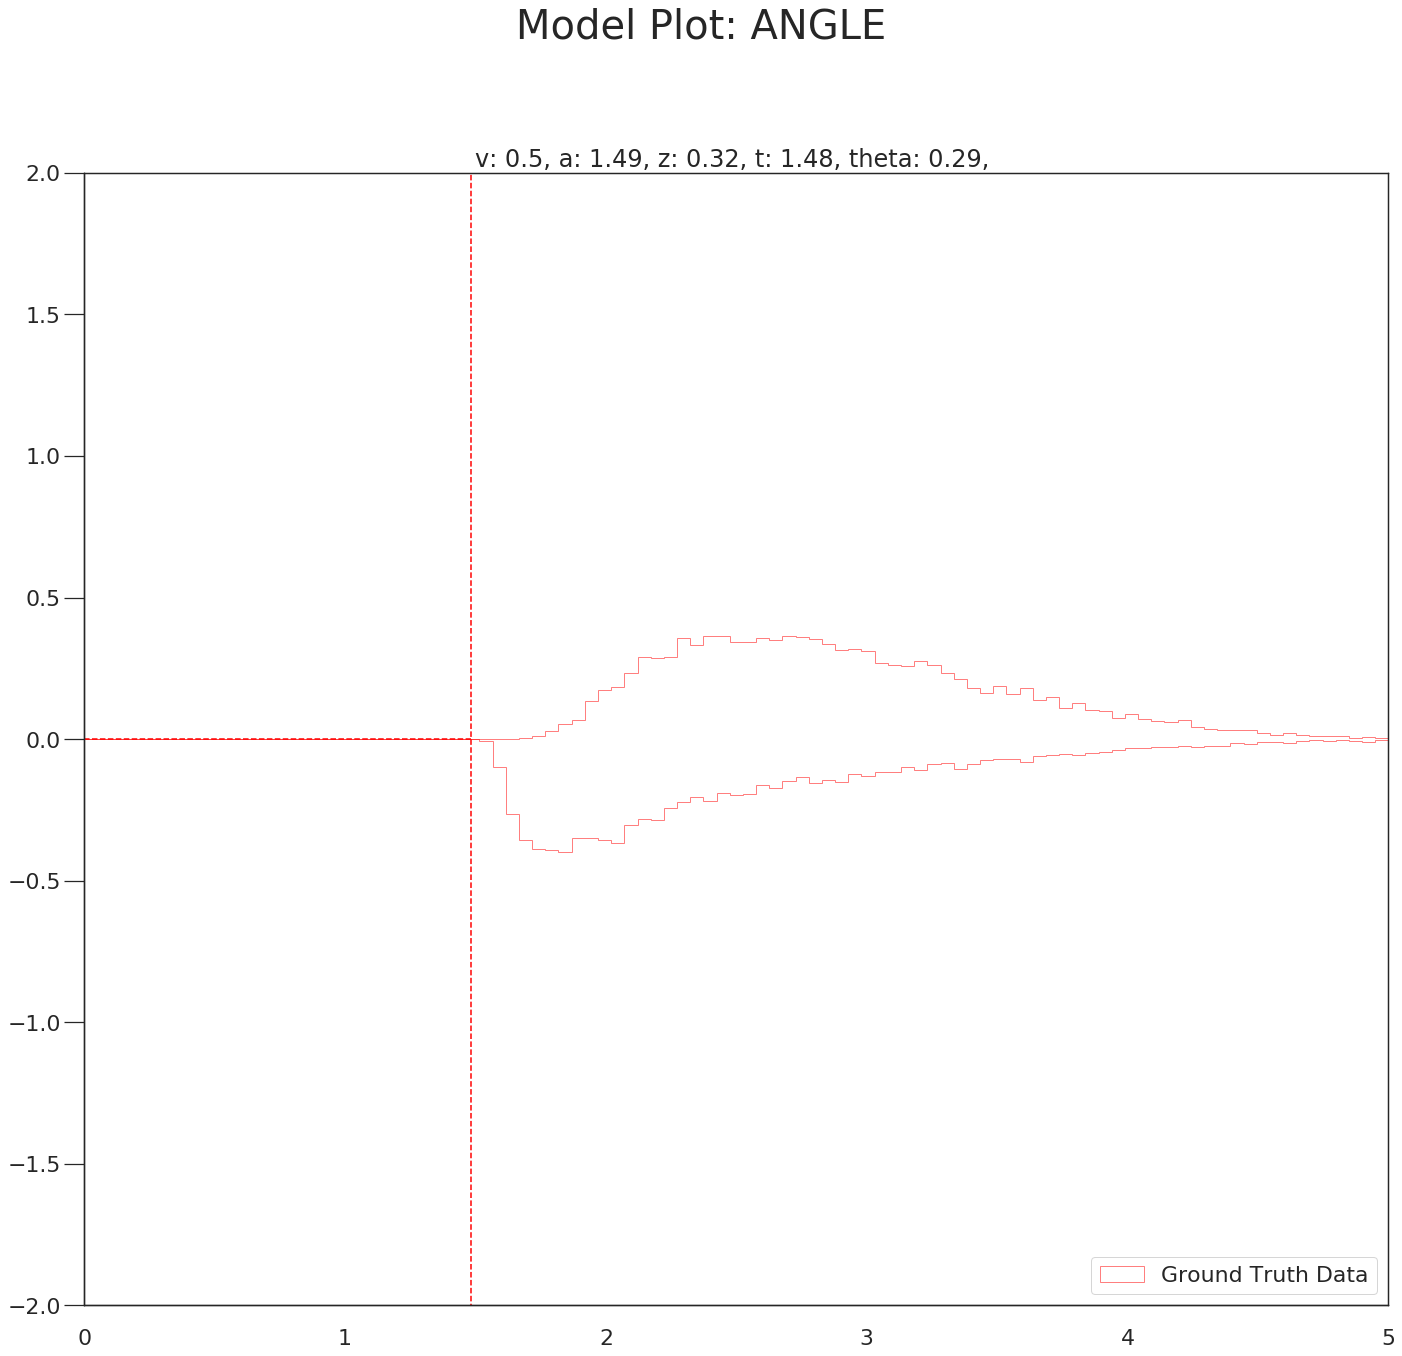

In [9]:
# Model Plots (Only data)
model_plot(ground_truths = angle_params.values[0],
           posterior_samples = None,
           cols = 1, 
           model_gt = 'angle',
           datatype = 'single_subject',
           n_plots = 1,
           max_t = 5,
           show_model = False)

In [10]:
# Look into the simulator
simulations

(array([[2.837541 ],
        [2.5595279],
        [2.772538 ],
        ...,
        [2.4775243],
        [1.7595336],
        [2.8615422]], dtype=float32),
 array([[ 1],
        [ 1],
        [-1],
        ...,
        [-1],
        [-1],
        [ 1]], dtype=int32),
 {'v': 0.5,
  'a': 1.4920976161956787,
  'w': 0.3190925717353821,
  'ndt': 1.4815336465835571,
  's': 1.0,
  'theta': 0.29039587132323635,
  'delta_t': 0.0010000000474974513,
  'max_t': 20.0,
  'n_samples': 2000,
  'simulator': 'ddm_flexbound',
  'boundary_fun_type': 'angle',
  'possible_choices': [-1, 1]})

### varying parameters

#### varying $a$

We look to investigate the ground truth data distribution when one parameter is changed very slightly. First, let's look at what happens for the angle model when $a$ varies from 0.5 to 1.5 in ten steps.

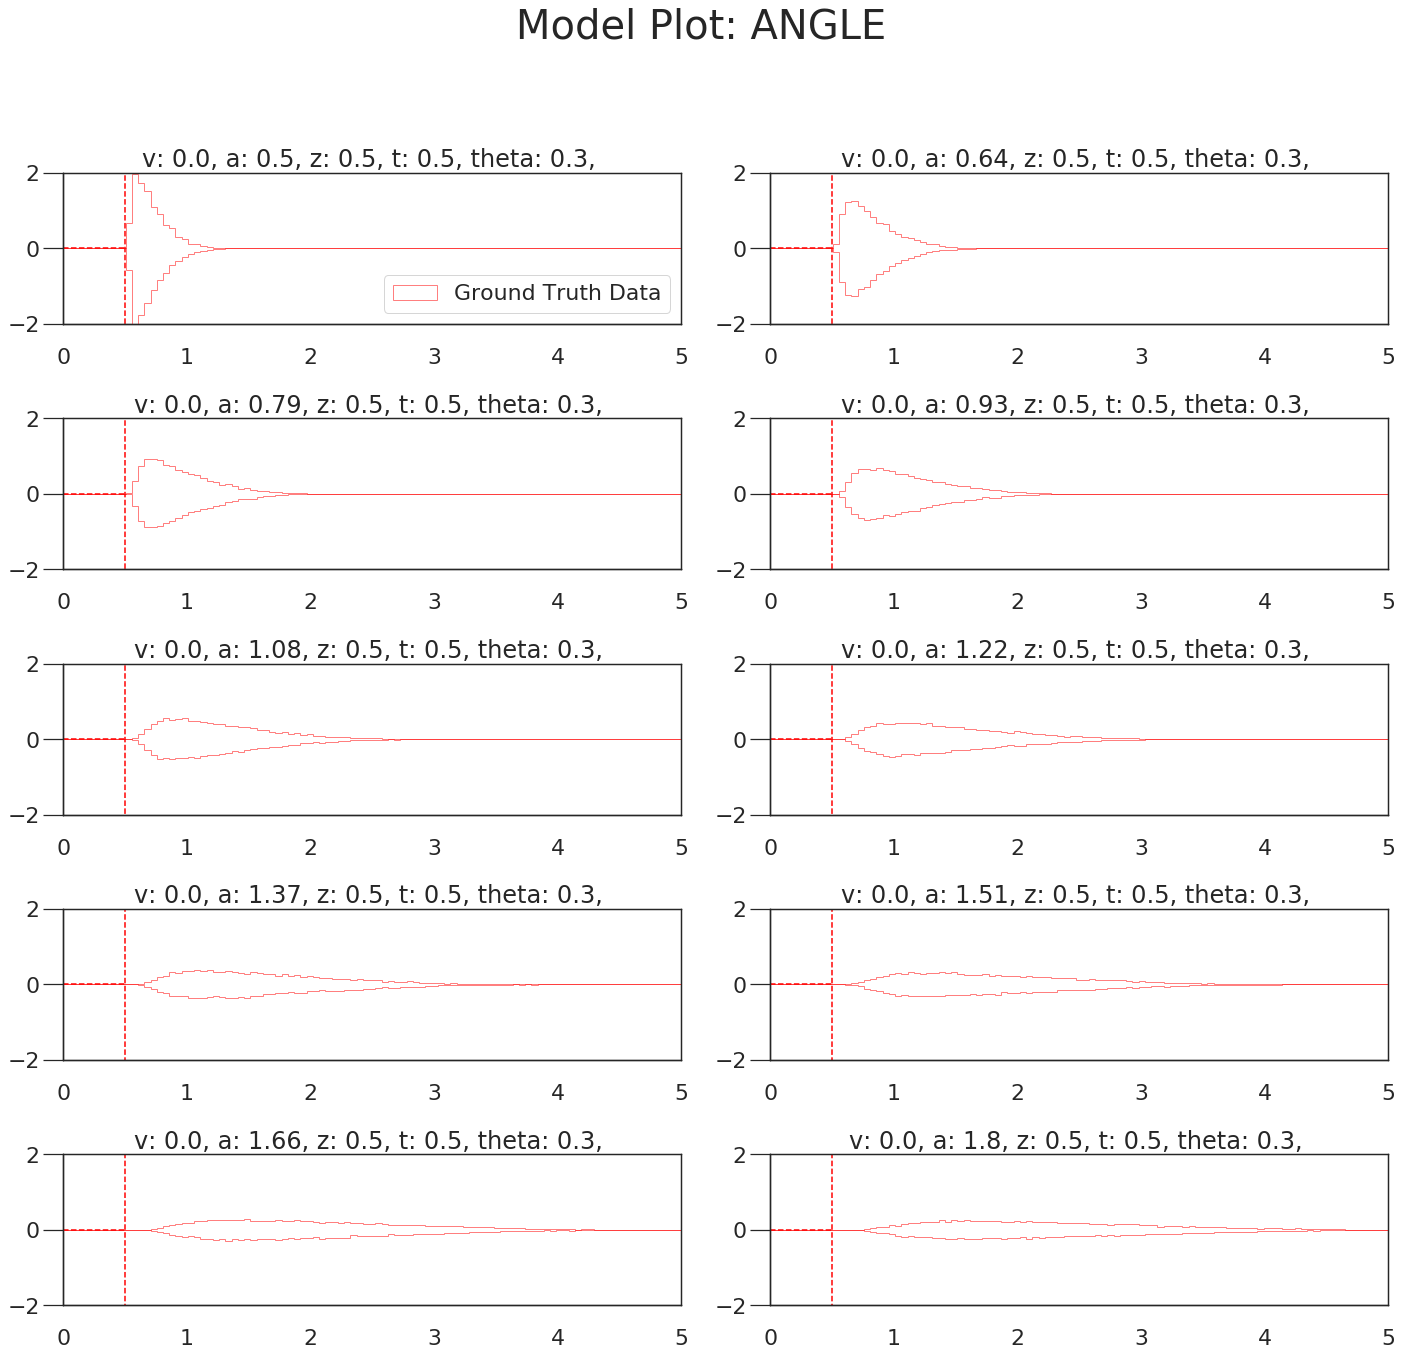

In [14]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [i for i in np.linspace(0.5, 1.8, 10)],
                                                 'v': [0],
                                                 'z': [0.5],
                                                 'theta': [0.3],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

Note that as $a$ increases, the data distribution becomes flatter and wider, or the participant is more likely to take very long before reaching a choice. This makes sense because as $a$ increases, more evidence is required before a choice is made, leading to long reaction times. For small $a$ values, little evidence is required and thus most of the reaction time is short.

Now let us fix $a$ at 1.0 and vary $v$ instead.

#### varying $v$ (in one direction)

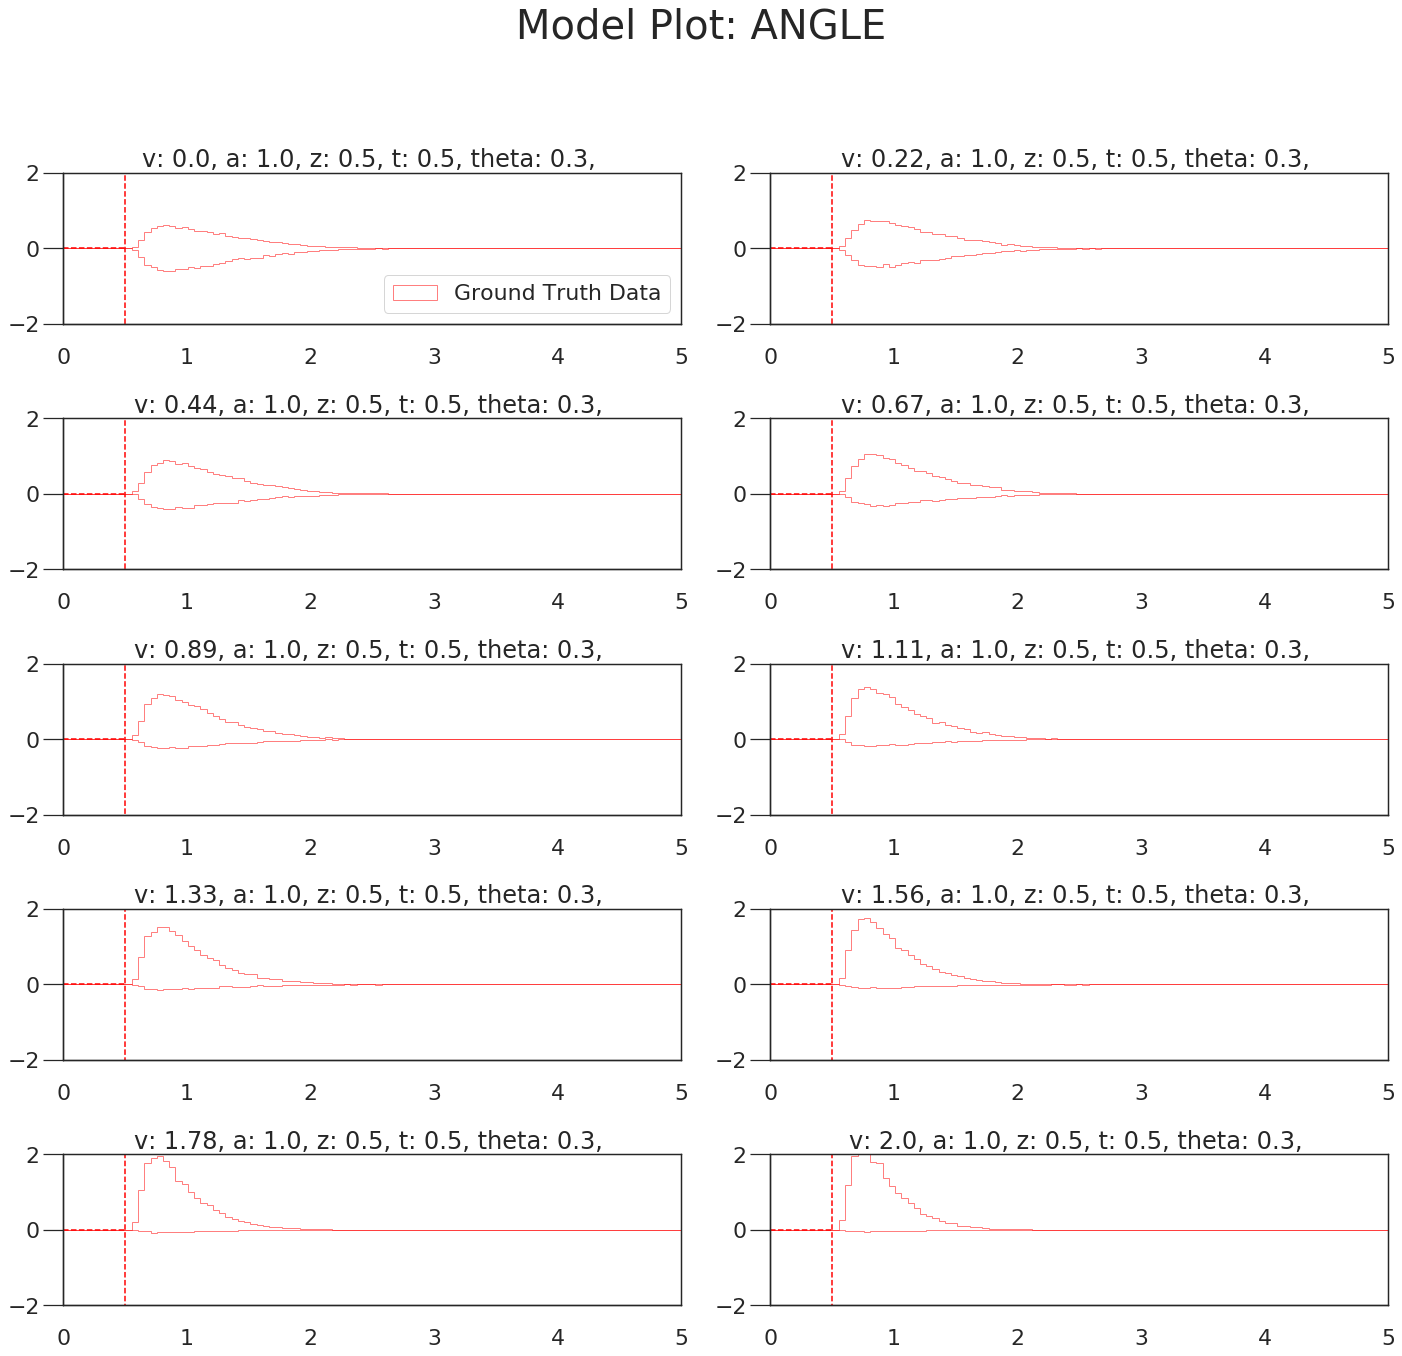

In [21]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [i for i in np.linspace(0, 2, 10)],
                                                 'z': [0.5],
                                                 'theta': [0.3],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

Similarly, we quickly look at varying $v$ from large negative values to large positive values.

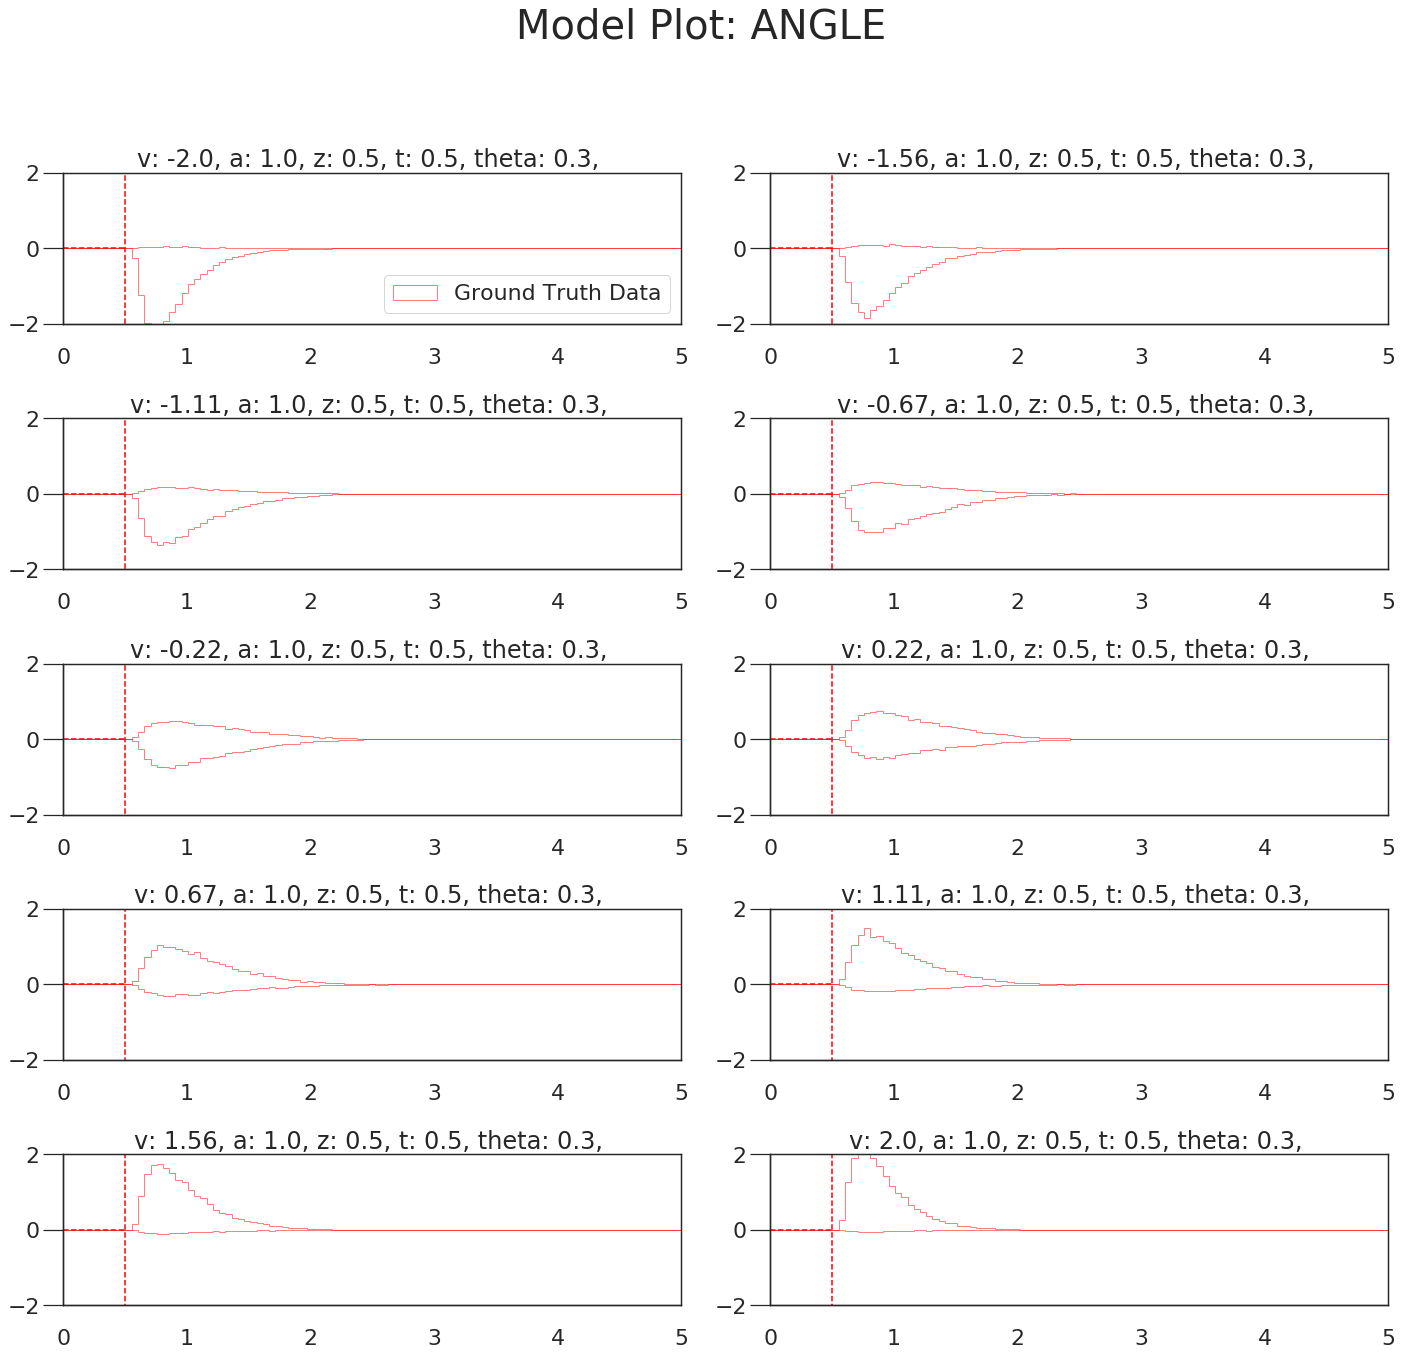

In [33]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [i for i in np.linspace(-2, 2, 10)],
                                                 'z': [0.5],
                                                 'theta': [0.3],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

We note that as |$v$| increases, we see an almost inverse effect to that of increasing $a$: the data becomes narrower. However note that small values of |$v$| (when there is little to none evidence for either choice) allow for choices in either direction, whereas high values of |$v$| (when there is strong evidence for one certain choice) will cause most data to fall to the direction of said choice.

Now let us vary $z$.
#### varying $z$


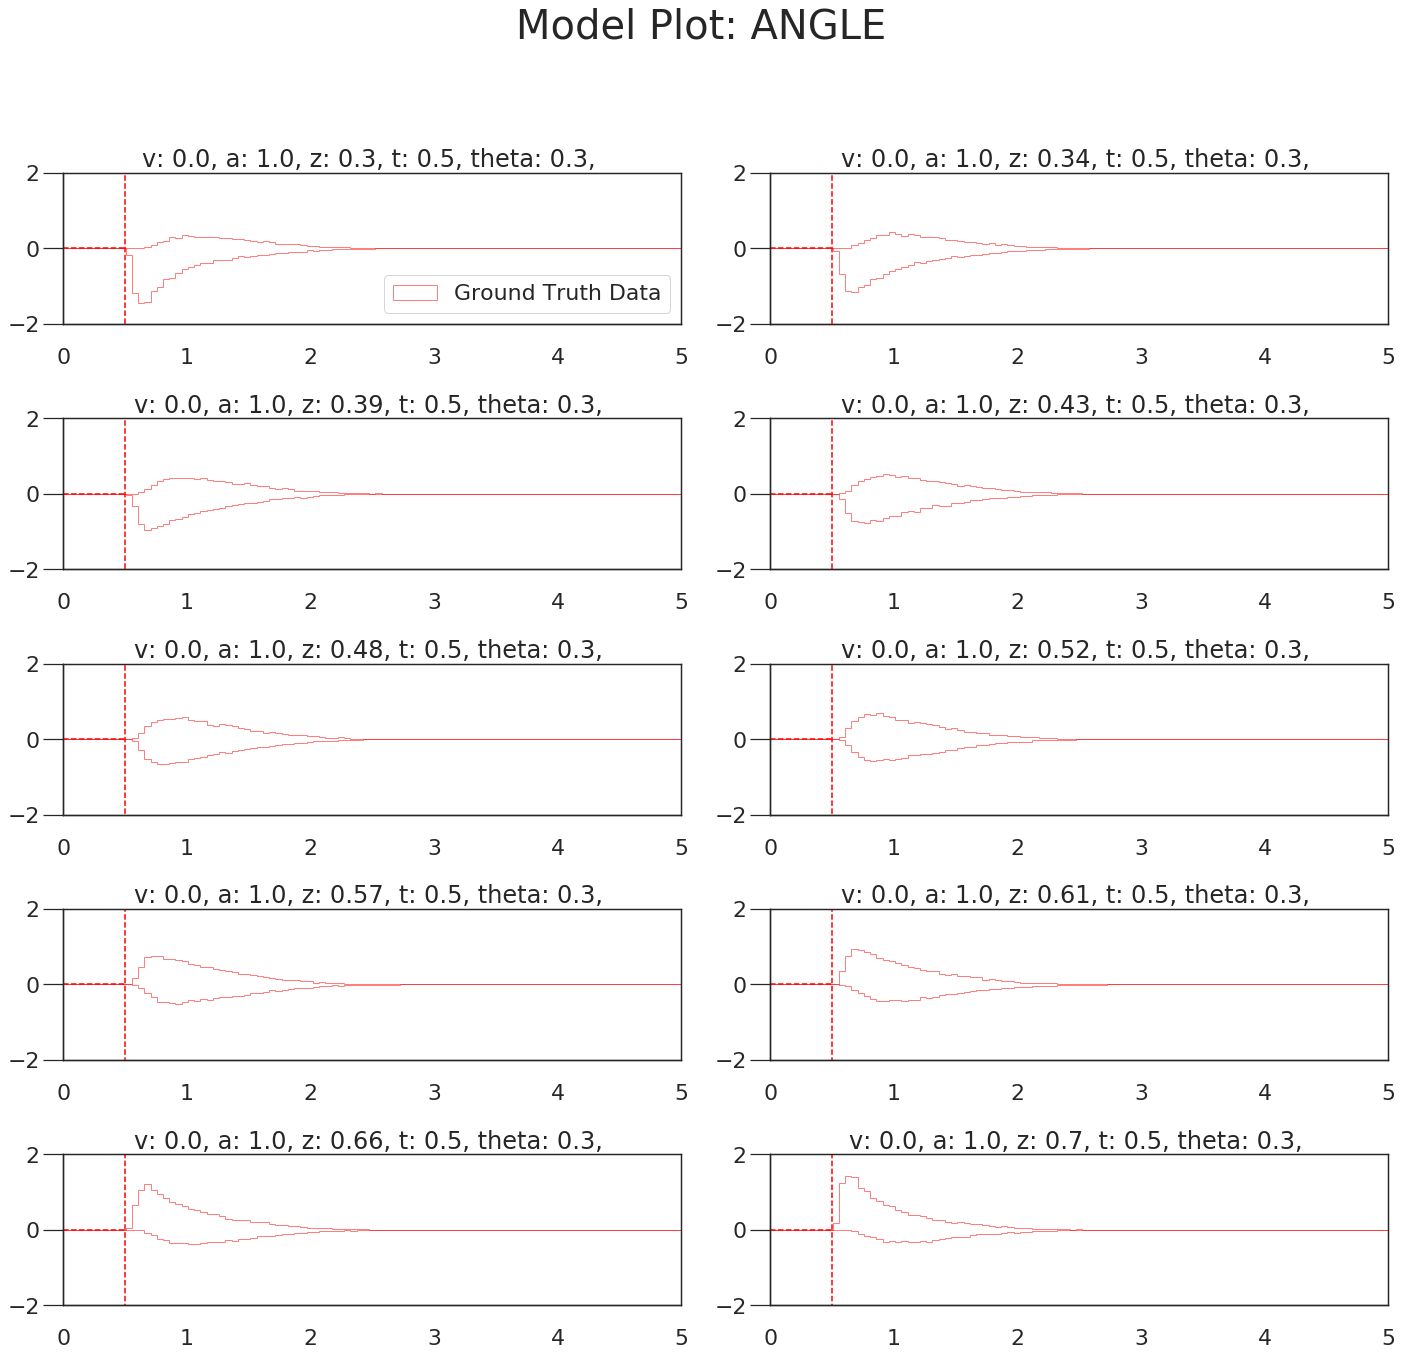

In [32]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [0],
                                                 'z': [i for i in np.linspace(0.3, 0.7, 10)],
                                                 'theta': [0.3],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

Recall that $z$ indicates bias towards a certain direction. Note that $v = 0.5$ implies almost no bias towards any direction. Lastly, let us vary $t$.

#### varying $t$

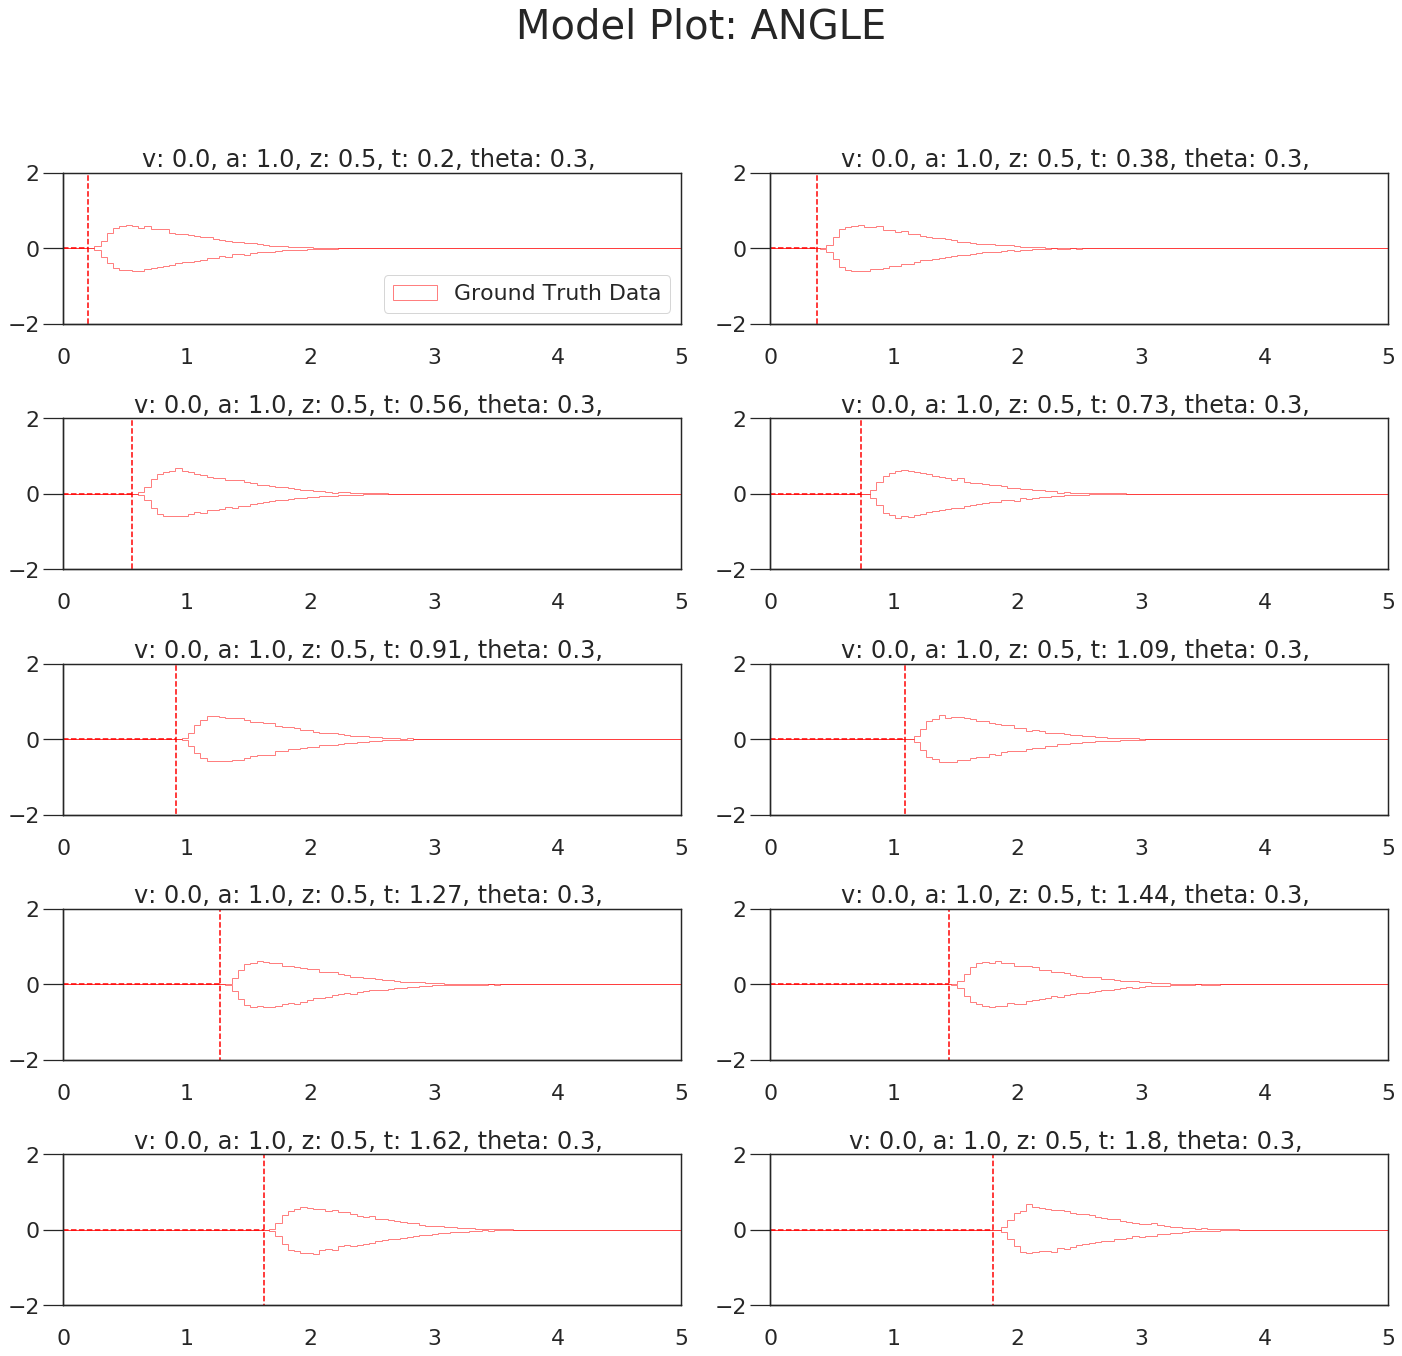

In [34]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [0],
                                                 'z': [0.5],
                                                 'theta': [0.3],
                                                 't': [i for i in np.linspace(0.2, 1.8, 10)]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

... yeah. Lastly, let us vary $\theta$.

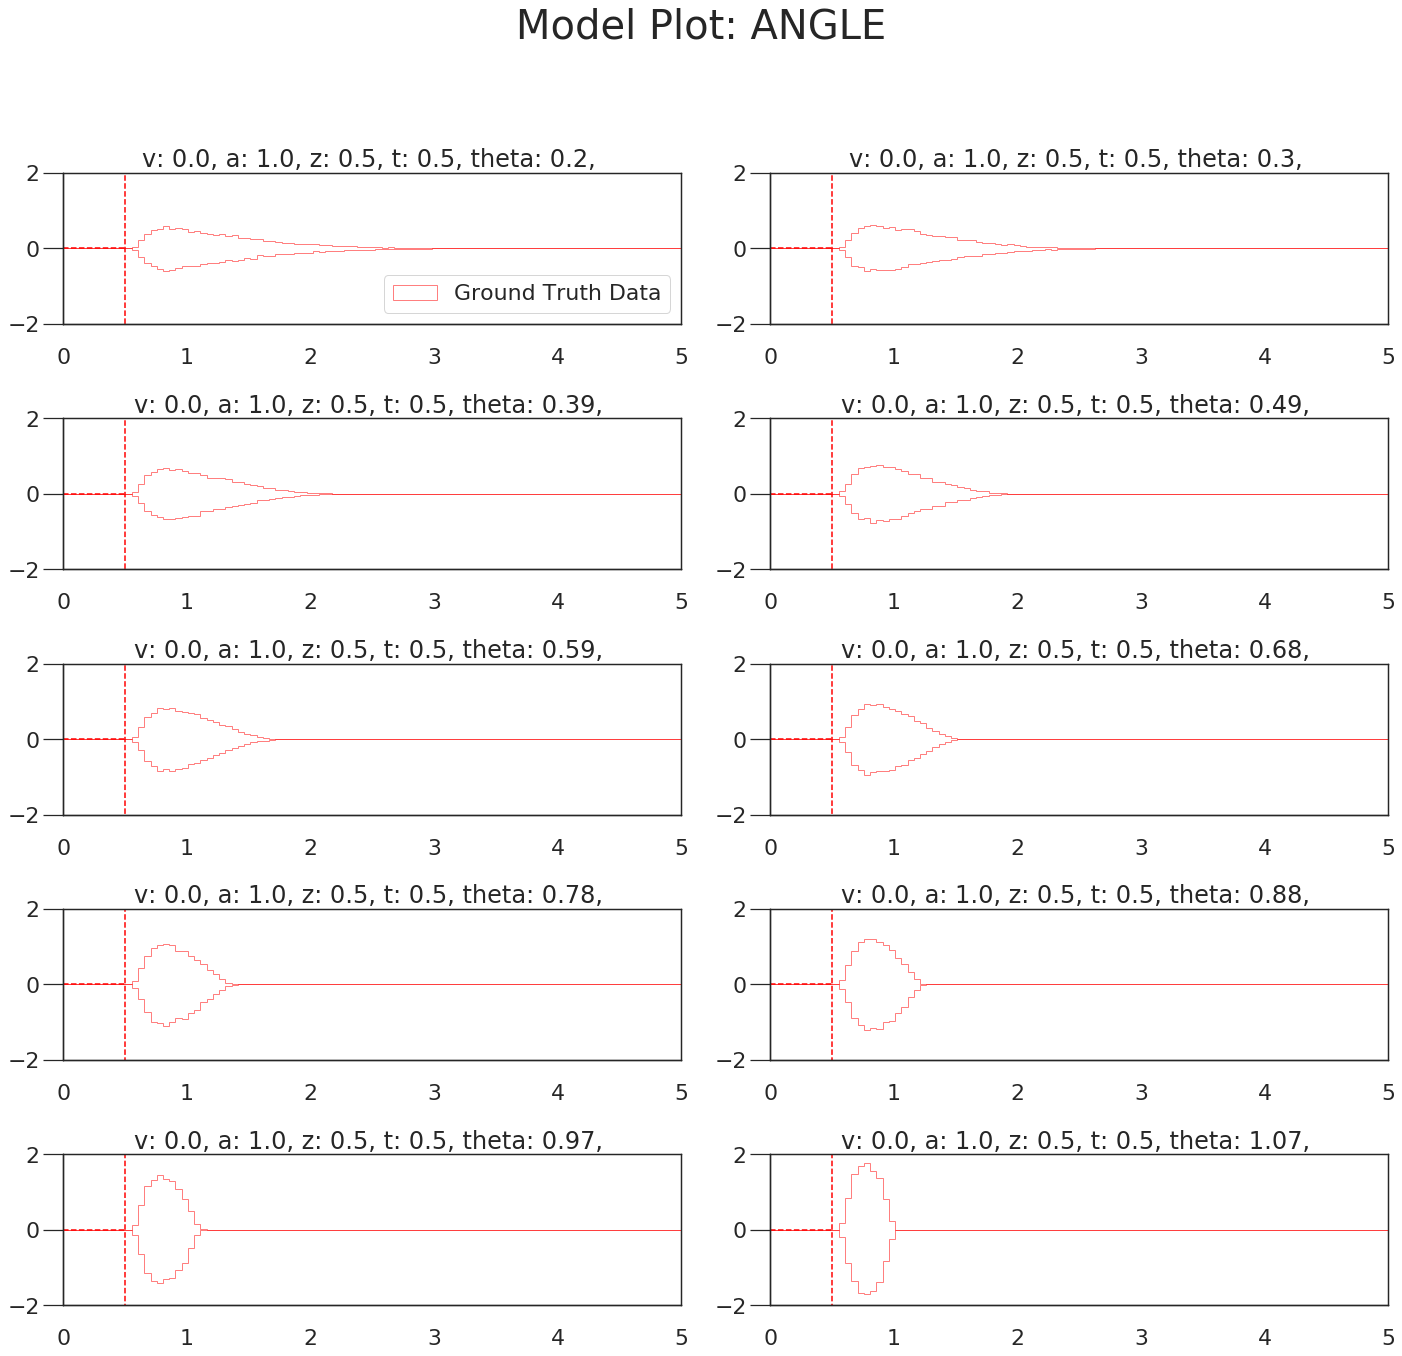

In [35]:
# Plotting the data
angle_params = make_parameter_sets(model = 'angle',
                                   n_parameter_sets = 10,
                                   param_dict = {'a': [1.0],
                                                 'v': [0],
                                                 'z': [0.5],
                                                 'theta': [i for i in np.linspace(0.2, np.pi / 2 - 0.5, 10)],
                                                 't': [0.5]})

# Model Plots (Only data)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = False)

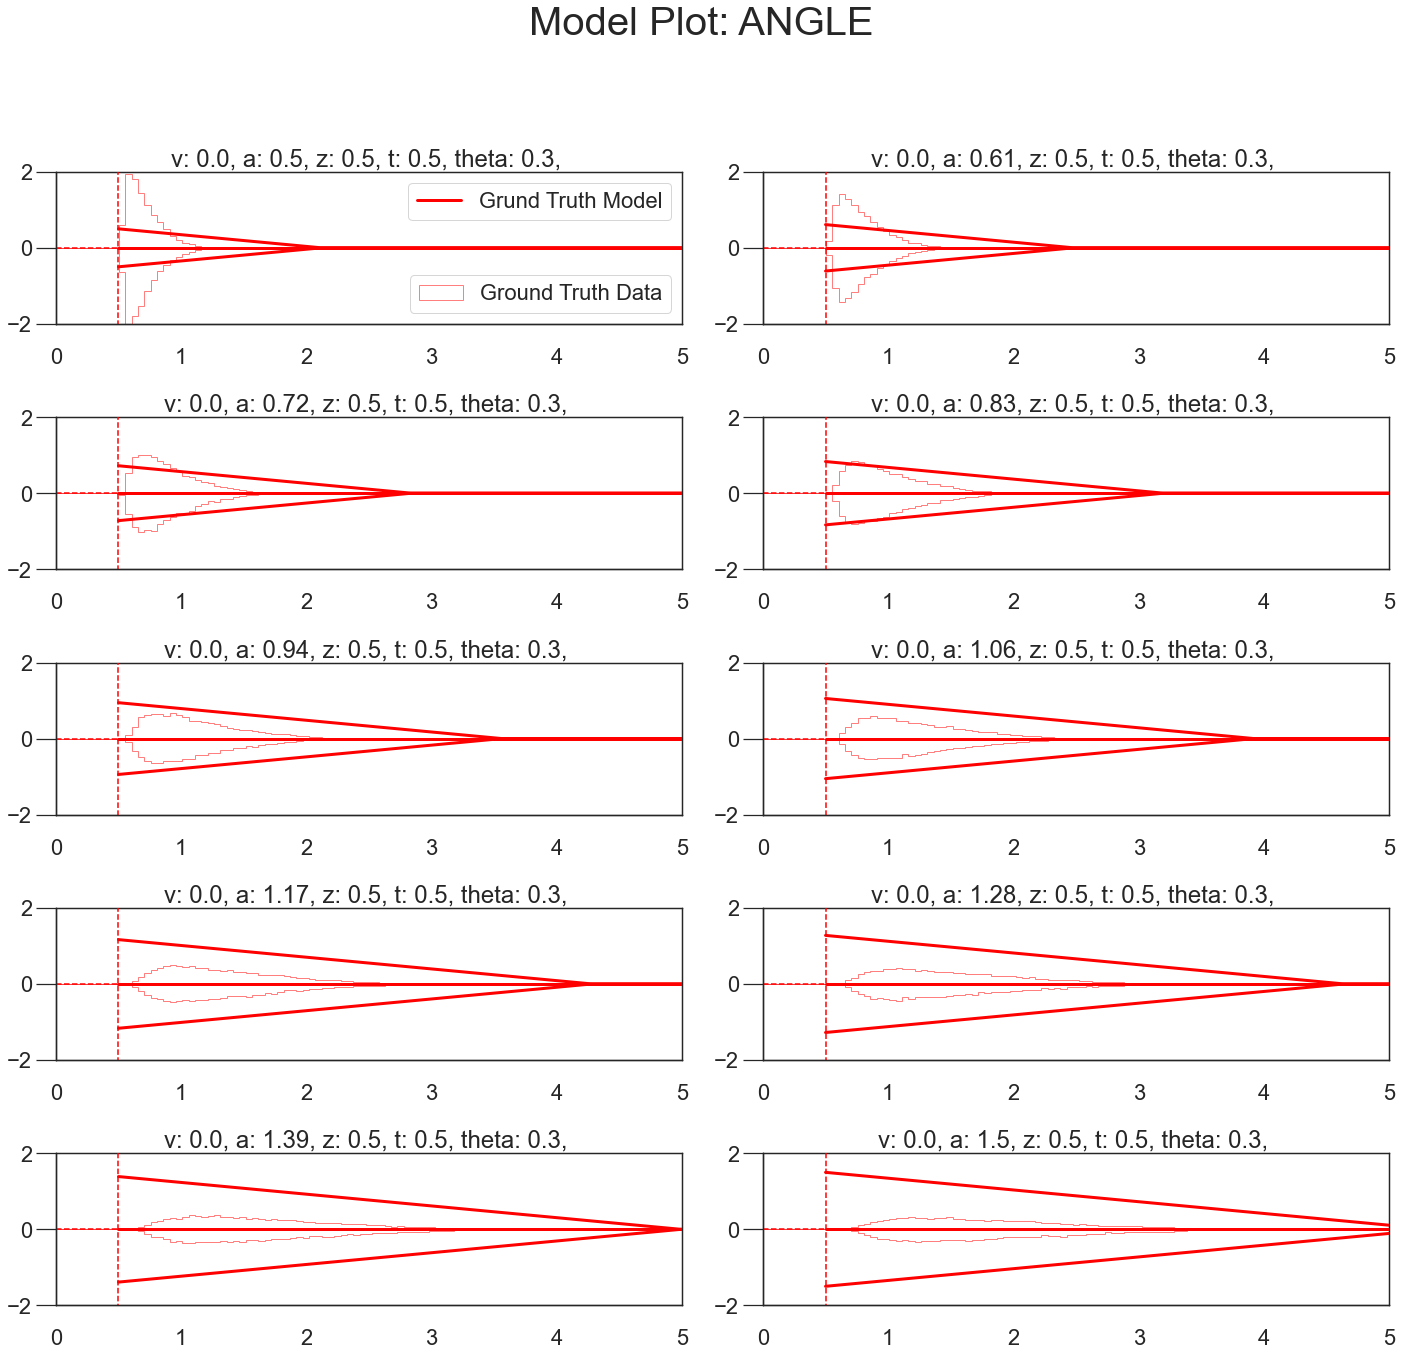

In [44]:
# Model Plot (Data + Model)
model_plot(ground_truths = angle_params.values,
           cols = 2, 
           model_gt = 'angle',
           n_plots = 10,
           max_t = 5,
           show_model = True)

# Section 2: Single subjects (collapsed data) fit

Now, we look to actually fit curves! First, let's fit a non-hierarchical fit - where we assume that there are no differences among each participants data. In other words, we have one giant participant that gives us all 1 000 datapoints.

In [ ]:
# TODO: PREPEND ANGLE EQUIVALENT PART

Ideally we would want to simulate a dataset from scratch and fitting it. However, due to time constraints, we will load in a dataset, its ground truth parameter and its trace. Note that the ``pickle`` is a tupule of:
0. The trace
1. Ground truth parameter
2. Dataset

In [6]:
# Load in the data
loadin = pickle.load(open('single_subject_weibull_n_1000.pickle', 'rb'))
weibull_params_s = loadin[1]
weibull_trace_s = loadin[0]
weibull_dataset_s = loadin[2]

Let's look at the ground truth parameter

In [22]:
weibull_params_s.values.flatten()

array([-0.41381021,  1.62247469,  0.41437494,  0.35040338,  1.51086104,
        2.29264431])

### hddm.HDDMnn_weibull(data, informative = False, free = False, k = True, include = ['z'], is_group_model = False)

Parameters:

- **data**: a ``pandas`` object - the dataset
- **informative**: bool, **True** if you want the model to talk to you while it's running
- **free**: bool, **False** if we are using parameters that have been trained on the network.
- **k**: bool, **True** to include $alpha$ in the fit
- **include**: a dictionary, whether or not to also fit $z$
- **is_group_model**: bool, **False** if fitting collapsed data, **True** if fitting hierarchical participant data.

In [44]:
# Defining a hddm model
hddm_model_single_subject = hddm.HDDMnn_weibull(weibull_dataset_s, 
                                                informative = False, 
                                                free = False, 
                                                k = True,
                                                include = ['z'],
                                                is_group_model = False)

Normally we would make the following call in order to draw samples. We present the output of said function (the trace ``pandas``) below. Note that since everything is stochastic, every run should give slightly different results.

In [45]:
nmcmc = 100
hddm_model_single_subject.sample(nmcmc, burn = 50, dbname='traces.db', db='pickle')
hddm_model_single_subject.save('mymodel')


 [-----------------101%-----------------] 101 of 100 complete in 46.9 sec

AttributeError: Can't pickle local object 'new_dist_class.<locals>.new_class'

In [39]:
hddm_model_single_subject.dbname

'pickle'

In [38]:
pickle.dump( hddm_model_single_subject, open( "weibull_model_s.pickle", "wb" ) )

ValueError: db is 'ram'. Saving a model requires a database on disk.

Now we look at the trace for said fit

In [8]:
# A look at the trace object
weibull_trace_s

,a,v,t,z_trans,beta,alpha
0,1.387207,-0.416730,0.422329,-0.371980,2.176990,2.385490
1,1.361826,-0.422416,0.436861,-0.404456,2.187864,2.375570
2,1.346161,-0.446058,0.446897,-0.423029,2.223950,2.379973
3,1.347924,-0.465763,0.452156,-0.433510,2.212851,2.424667
4,1.339708,-0.360379,0.470504,-0.443158,2.184911,2.498354
...,...,...,...,...,...,...
1295,1.493241,-0.353431,0.397367,-0.391684,2.135403,1.870288
1296,1.502603,-0.392678,0.394709,-0.464858,2.196307,2.271212
1297,1.440646,-0.386815,0.409491,-0.433563,2.177082,2.020274
1298,1.444854,-0.355967,0.429558,-0.444941,2.135001,2.230030


Does anyone know what information the trace contains?

Now that we have run a fit, we look to find ways to visualised the recovered parameters to make sure the model is performing accurately. A caterpillar plot is a good way to visualise both the precision and accuracy of the task. Here, the red dot represents the ground truth value. The black bars are where the trace lies, with the black box indicating < > percentile.

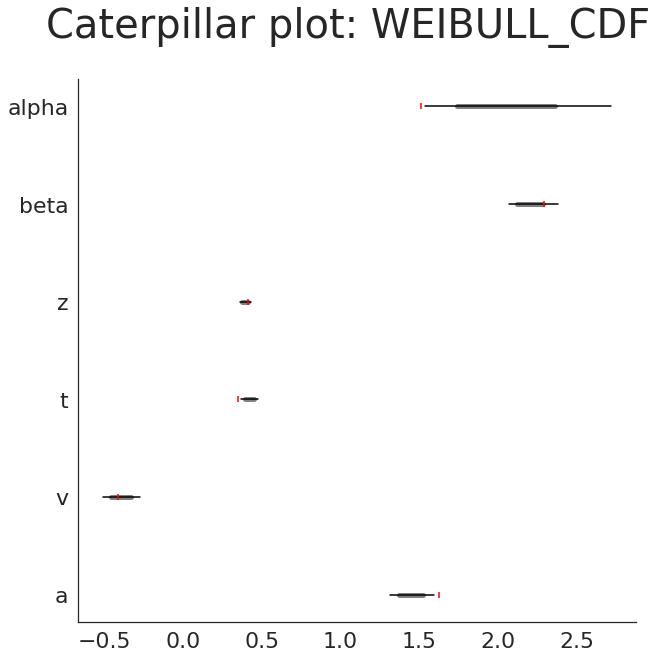

In [9]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = weibull_trace_s,
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

From the graph, we note that the recovery of $v$, $z$ and $\beta$ are on point. We are slightly overestimating $t$ (with a small variance) and significantly overestimating $\alpha$ (which has a large variance). We are also slightly overestimating $a$.

### Posterior Predictive
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. Note that the parameter ``n_post_params`` controls the number of traces drawn. Here we draw randomly 500 (out of 1200).

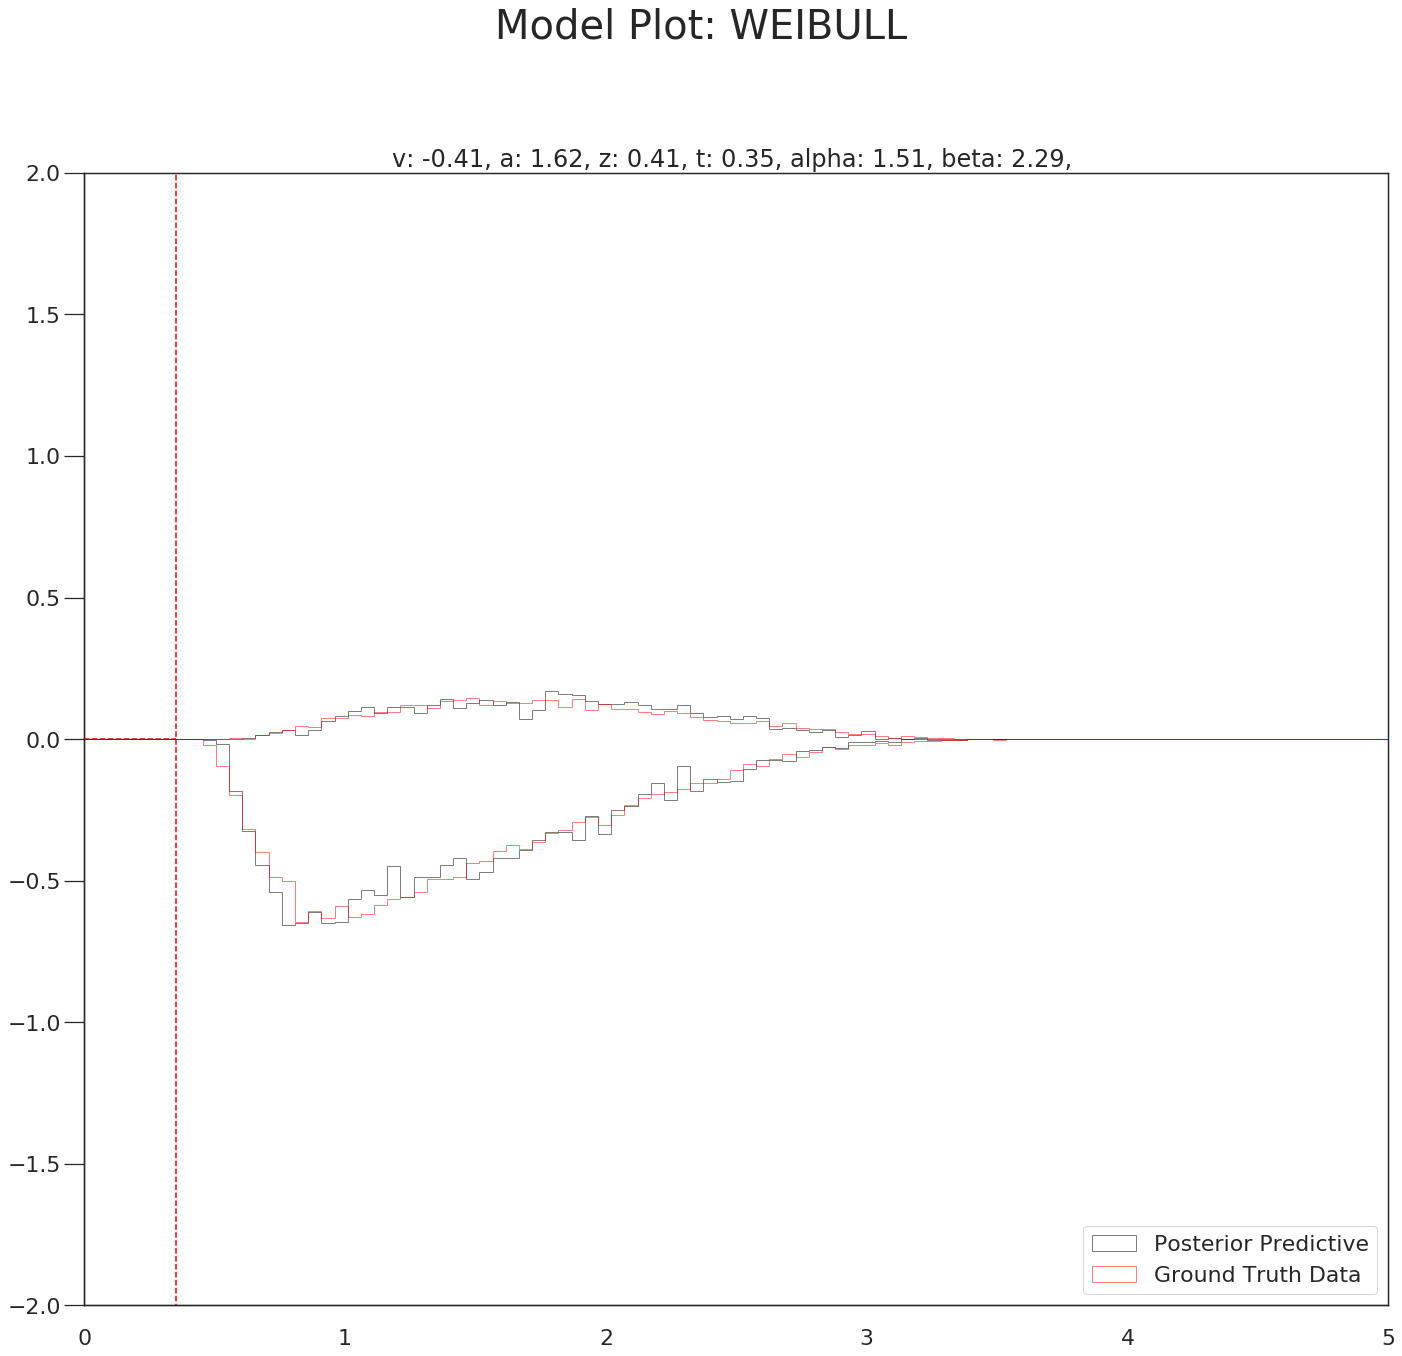

In [26]:
# Posterior Predictive: Do we generate meaningful data from the Posterior Model?
model_plot(ground_truths = weibull_params_s.values.flatten(),
           posterior_samples = weibull_trace_s,
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 500,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = False,
           input_hddm_trace = True,
           datatype = 'single_subject')

We can also overlay the traces on the previous plot to see whether or not the trace is making sense. Every black line/curve is one trace's parameter. The wider a bundle the curves make, the more variability there is in the trace. The more they form one solid dark line, the less variability.

passed through legend part
0
0


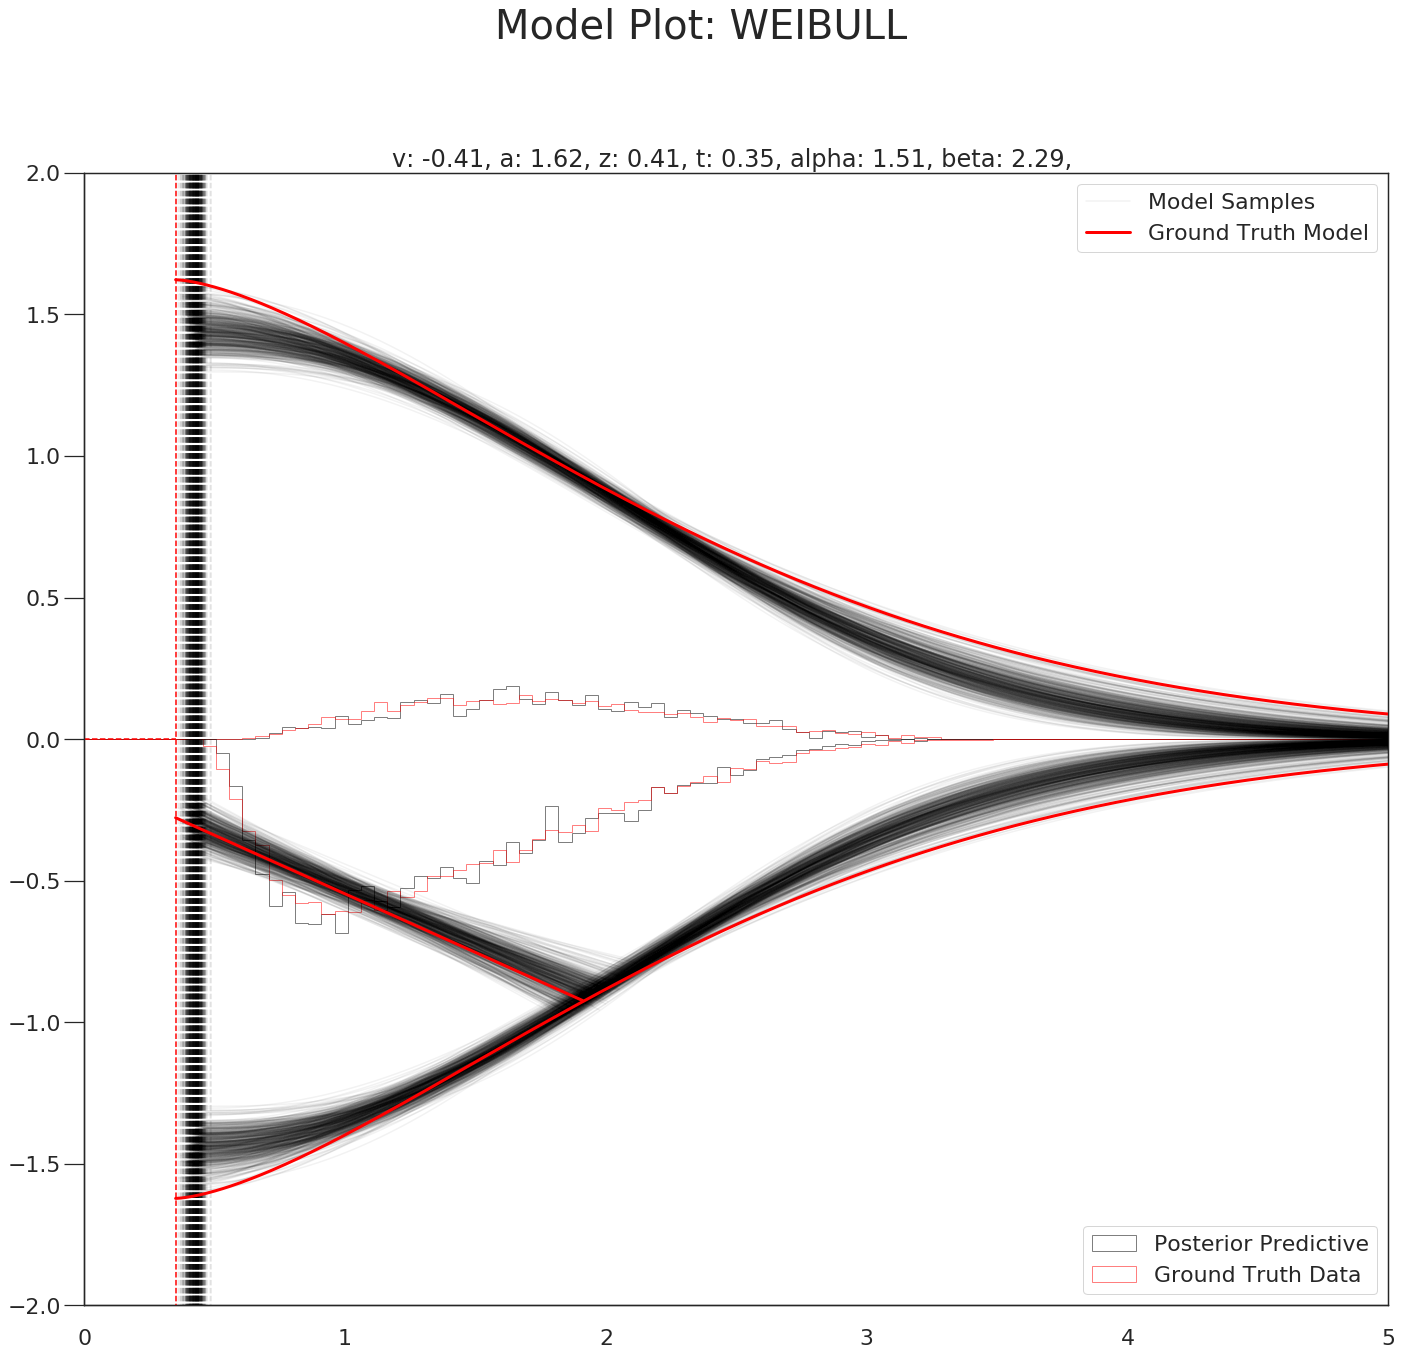

In [24]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params_s.values.flatten(),
           posterior_samples = weibull_trace_s,
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 500,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

We note here that in general, this plot makes sense given the ground truth values. We have $v$ skewing the data towards the negative choice - note that a considerable part of the data is towards the direction of $v$. In other words, since this task is relatively skewed towards negative choice and relatively easy, we mostly get data where the participant very quickly chooses the negative choice. This gives us a lot of data in this time-region, and thus our recovery is the most accurate in this zone. Now, as you go further and further away from this zone, you get less and less data, and our recovery becomes less accurate. 

#### A small note on convergence

Note that the MCMC algorithm requires the chain to converge.There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correltion plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly.

In [28]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddm_model_single_subject.plot_posteriors(['a', 't', 'v', 'z', 'alpha', 'beta'])

NameError: name 'hddm_model_single_subject' is not defined

In [27]:
#
# Pairwise posterior plot
posterior_pair_plot(posterior_samples = weibull_trace_s,
                    height = 10,
                    aspect = 1,
                    n_subsample = 1000,
                    ground_truths = weibull_params.values[0],
                    model = 'weibull_cdf')

AttributeError: 'DataFrame' object has no attribute 'get_traces'

Now we look to repeat the same process for the angle model.

In [72]:
data = pickle.load(open("single_subject_weibull_n_1000.pickle", "rb"))
angle_trace_s = data[0]
angle_params_s = data[1]
angle_dataset_s = data[2]

In [62]:
angle_params_s

,v,a,z,t,alpha,beta
0,-0.41381,1.622475,0.414375,0.350403,1.510861,2.292644


In [ ]:
# Caterpillar Plot: 
caterpillar_plot(posterior_samples = angle_trace_s,
                 ground_truths = angle_params.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

In [ ]:
# Posterior Predictive: 
model_plot(ground_truths = angle_params_s.values.flatten(),
           posterior_samples = angle_trace_s,
           model_gt = 'angle',
           model_fitted = 'angle',
           n_post_params = 500,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = False,
           input_hddm_trace = True,
           datatype = 'single_subject')

In [ ]:
# Posterior Predictive with model line
model_plot(ground_truths = angle_params_s.values.flatten(),
           posterior_samples = angle_trace_s,
           model_gt = 'angle',
           model_fitted = 'angle',
           n_post_params = 500,
           cols = 1,
           n_plots = 1,
           max_t = 5, 
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

In [56]:
a_simulations = simulator(theta = angle_params.values[0],
                        model = 'angle', 
                        n_samples = 2000)
a_process = hddm_preprocess(a_simulations)

In [57]:
hddm_model_single_subject = hddm.HDDMnn_angle(a_process, 
                                                informative = False, 
                                                free = False, 
                                                include = ['z'],
                                                is_group_model = False)

In [58]:
hddm_model_single_subject.sample(1500,burn = 200, dbname = 'traces.db', db = 'pickle')

 [-----------------100%-----------------] 1501 of 1500 complete in 937.6 sec

In [59]:
pickle.dump((hddm_model_single_subject.get_traces(), angle_params,a_process), open("single_subject_angle_n_1000.pickle", "wb") )

# Section 3: Fitting hierarchical model

The 'h' in `hddm` stands for hierarchical, so let's do it! Recall that we fit our collapsed data in Section 2. What if we fit our data without collapsing it? Essentially what we are doing here is form a *hierarchy* of data, where each participant has their own parameters.

For a quick refresher on hierarchical Bayes, recall our favourite Bayes rule: 
$$p(\theta | x) \propto  p(x | \theta) \times p(\theta)$$

where $x$ represents our (rt, choice) data and $\theta$ represents our vector of parameters. We call $p(\theta | x)$ the *posterior*, $p(x | \theta)$ the *likelihood*  and $p(\theta)$ the *prior*. Bayes rule is stating that the posterior distribution of a parameter is proportionate to the likelihood of observed data given parameter multiplied by the *marginal distribution* of said parameter. This is where the hierarchy aspect lies, since $p(\theta)$ is the marginalisation of a higher levelled parameter (how the local participant parameters are distributed). And, like a usual distribution, we can look to estimate these *global parameters* - in this case, we assume that our pior is normal, giving us two parameters: mean and standard deviation.

**Remark**: we do not need to stop at one hierarchy! For example, we could add another hierarchy called 'condition' whereby $v$ changes. Then, every participant will have separate data for each condition. We would then need to specify a prior for $v$ (which is conditioned on $\theta$).

In [ ]:
# SOME EXPLANATIONS ON THE KIND OF HIERARCHICAL MODEL WE FIT HERE

In [ ]:
# ANGLE MODEL

In [54]:
hddm_data_hierarchical_angle = hddm_preprocess_hierarchical(model = 'angle', 
                                                            datasetid = 0)

In [66]:
hddm_data_hierarchical_angle[0]

,response,rt,subj_idx,nn_response
0,0.0,2.202141,0.0,-1.0
1,1.0,1.756146,0.0,1.0
2,0.0,1.698147,0.0,-1.0
3,0.0,2.064142,0.0,-1.0
4,0.0,1.943144,0.0,-1.0
...,...,...,...,...
4995,0.0,2.491104,4.0,-1.0
4996,1.0,2.261105,4.0,1.0
4997,1.0,1.878110,4.0,1.0
4998,0.0,2.188106,4.0,-1.0


In [63]:
hddm_hierarchical_model_angle = hddm.HDDMnn_angle(hddm_data_hierarchical_angle[0], 
                                            free = False,  
                                            informative = False, 
                                            include = 'z',
                                            is_group_model = True)



In [65]:
# Sampling:
nmcmc = 1000
hddm_hierarchical_model_angle.sample(nmcmc,
                               burn = 200, 
                               dbname = 'traces_hierarchical_angle_tutorial.db', 
                               db = 'pickle')

 [-----------------100%-----------------] 1001 of 1000 complete in 3531.6 sec

In [70]:
loadin = pickle.load(open("hierarchy_n_1000.pickle", "rb") )

In [73]:
#Trace info
angle_trace_h = loadin[0]
angle_params_h = loadin[1]
angle_dataset_h = loadin[2]

In [74]:
angle_dataset_h

,response,rt,subj_idx,nn_response
0,0.0,2.202141,0.0,-1.0
1,1.0,1.756146,0.0,1.0
2,0.0,1.698147,0.0,-1.0
3,0.0,2.064142,0.0,-1.0
4,0.0,1.943144,0.0,-1.0
...,...,...,...,...
4995,0.0,2.491104,4.0,-1.0
4996,1.0,2.261105,4.0,1.0
4997,1.0,1.878110,4.0,1.0
4998,0.0,2.188106,4.0,-1.0


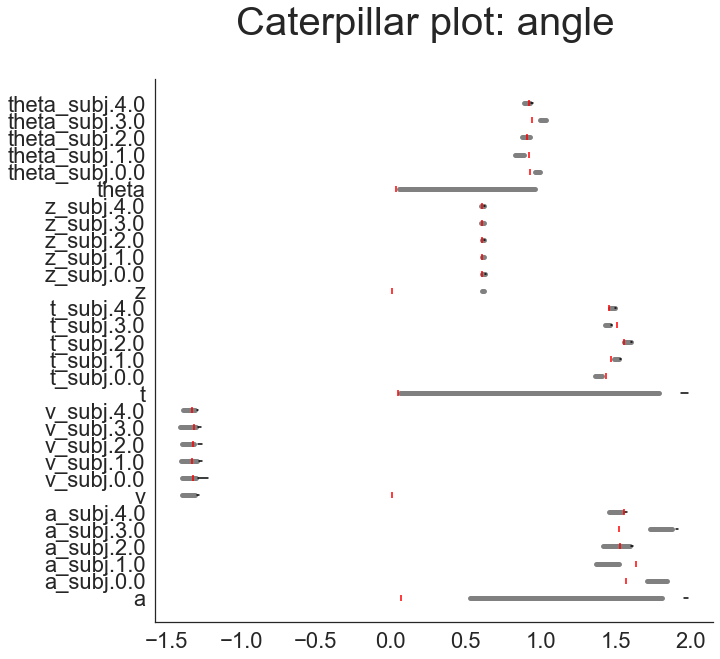

In [47]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_hierarchical_model_angle.get_traces(),
                 ground_truths = hddm_data_hierarchical_angle,
                 model = 'angle',
                 datatype = 'hierarchical',
                 drop_sd = True)

5


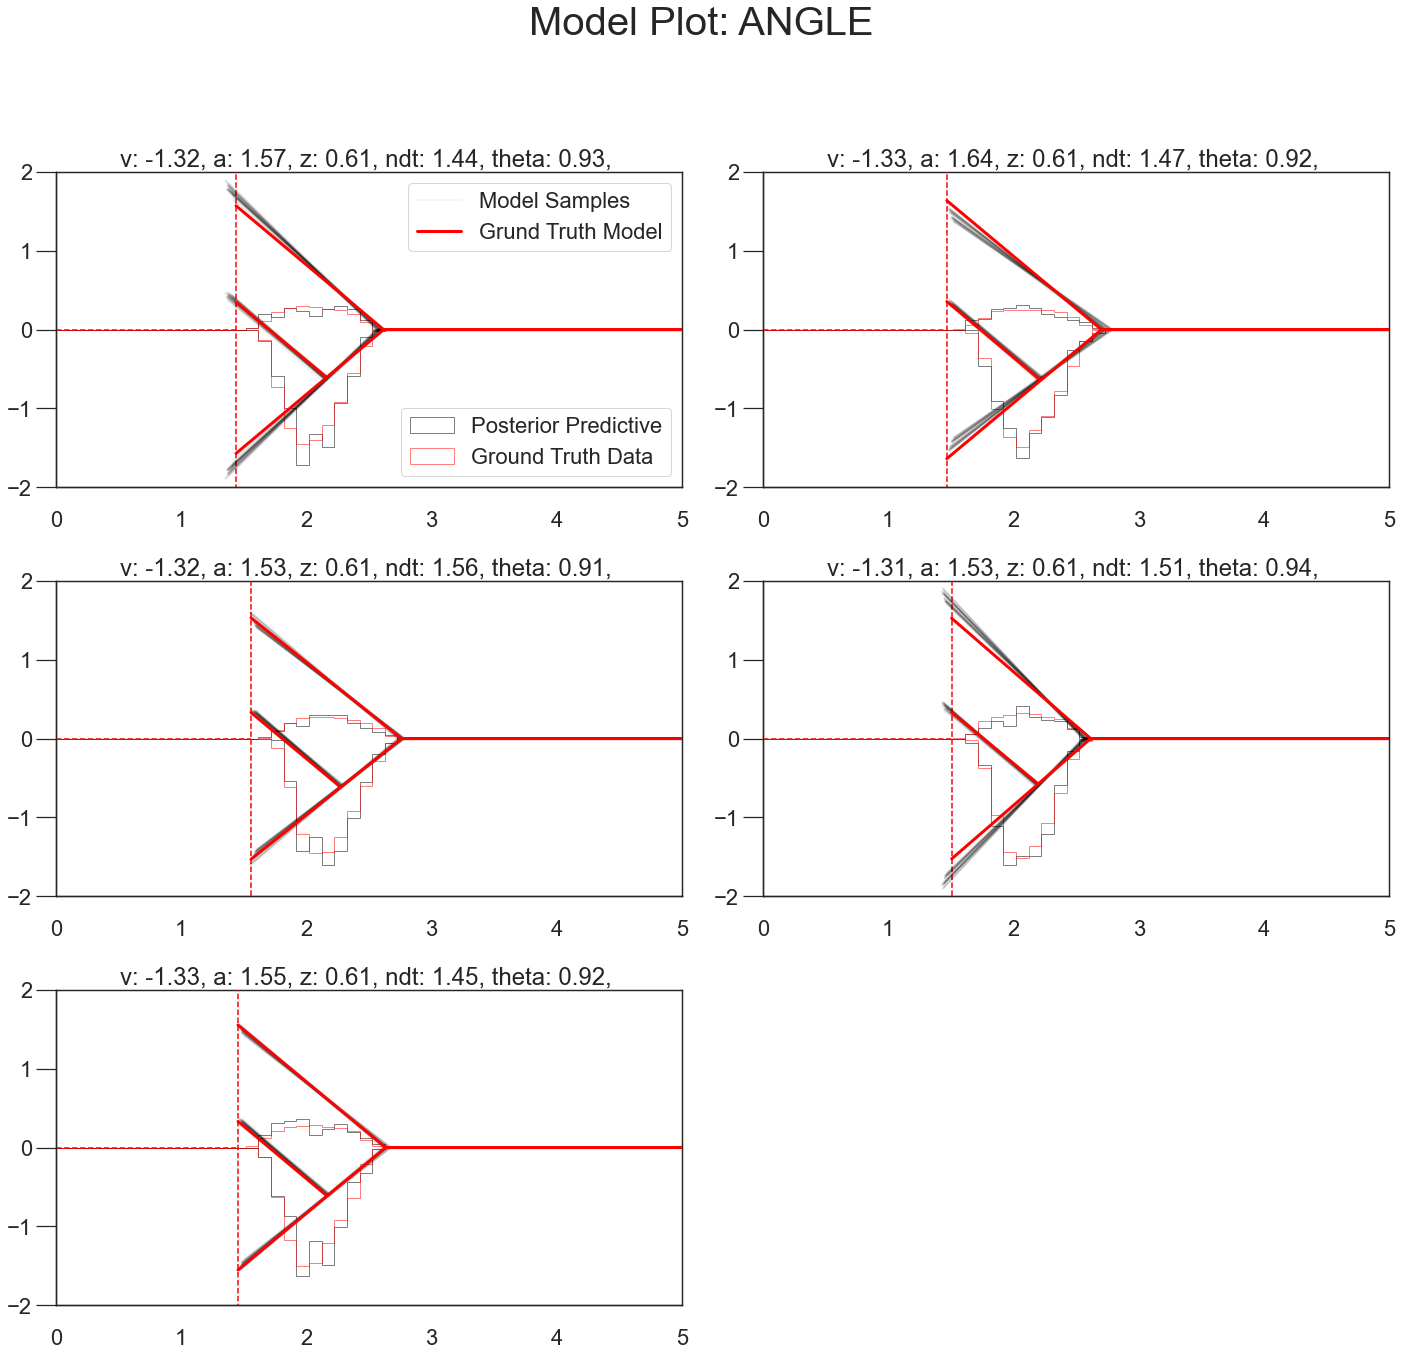

In [48]:
# Posterior Predictive
model_plot(ground_truths = hddm_data_hierarchical_angle[1].values,
           posterior_samples = hddm_hierarchical_model_angle.get_traces(),
           input_hddm_trace = True,
           n_post_params = 50,
           cols = 2, 
           model_gt = 'angle',
           model_posterior = 'weibull_cdf',
           datatype = 'hierarchical',
           n_plots = 5,
           max_t = 5,
           show_model = True)

In [28]:
# WEIBULL
hddm_data_hierarchical_weibull_cdf = hddm_preprocess_hierarchical(model = 'weibull_cdf', 
                                                                  datasetid = 1)

In [8]:
hddm_data_hierarchical_weibull_cdf

(      response        rt  subj_idx  nn_response
 0          1.0  2.125856       0.0          1.0
 1          1.0  1.877859       0.0          1.0
 2          0.0  2.042857       0.0         -1.0
 3          0.0  2.124856       0.0         -1.0
 4          1.0  2.590876       0.0          1.0
 ...        ...       ...       ...          ...
 4995       0.0  2.953006       4.0         -1.0
 4996       0.0  2.591989       4.0         -1.0
 4997       0.0  1.353976       4.0         -1.0
 4998       1.0  2.305975       4.0          1.0
 4999       0.0  2.496984       4.0         -1.0
 
 [5000 rows x 4 columns],
           v         a         z         t     alpha      beta
 0 -0.060218  1.313313  0.384968  1.151865  2.133997  1.569213
 1 -0.075177  1.290445  0.435621  1.098726  2.150635  1.658163
 2 -0.066992  1.307375  0.411264  1.150821  2.203776  1.542108
 3 -0.137658  1.285835  0.425311  1.098753  2.142593  1.626302
 4 -0.066513  1.310350  0.429493  1.122976  2.156340  1.734752,
     

In [5]:
hddm_hierarchical_model_weibull_cdf = hddm.HDDMnn_weibull(hddm_data_hierarchical_weibull_cdf[0], 
                                                         free = False,  
                                                         informative = False, 
                                                         include = 'z',
                                                         k = True,
                                                         is_group_model = True)

In [6]:
nmcmc = 100
hddm_hierarchical_model_weibull_cdf.sample(nmcmc, burn = 50)

 [-----------------101%-----------------] 101 of 100 complete in 215.9 sec

In [ ]:
hddm_hierarchical_model_weibull_cdf.get_traces()

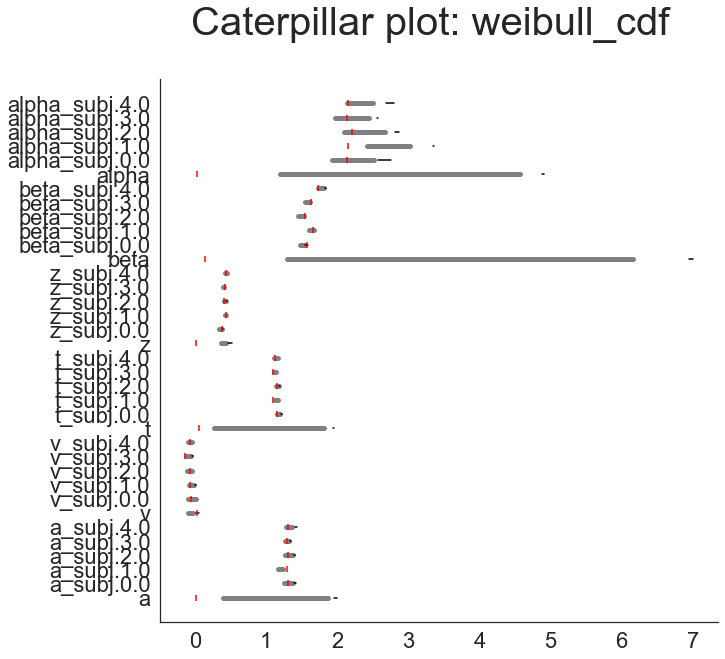

In [7]:
# Caterpillar Plot
caterpillar_plot(posterior_samples = hddm_hierarchical_model_weibull_cdf.get_traces(),
                 ground_truths = hddm_data_hierarchical_weibull_cdf,
                 model = 'weibull_cdf',
                 datatype = 'hierarchical',
                 drop_sd = True)

5


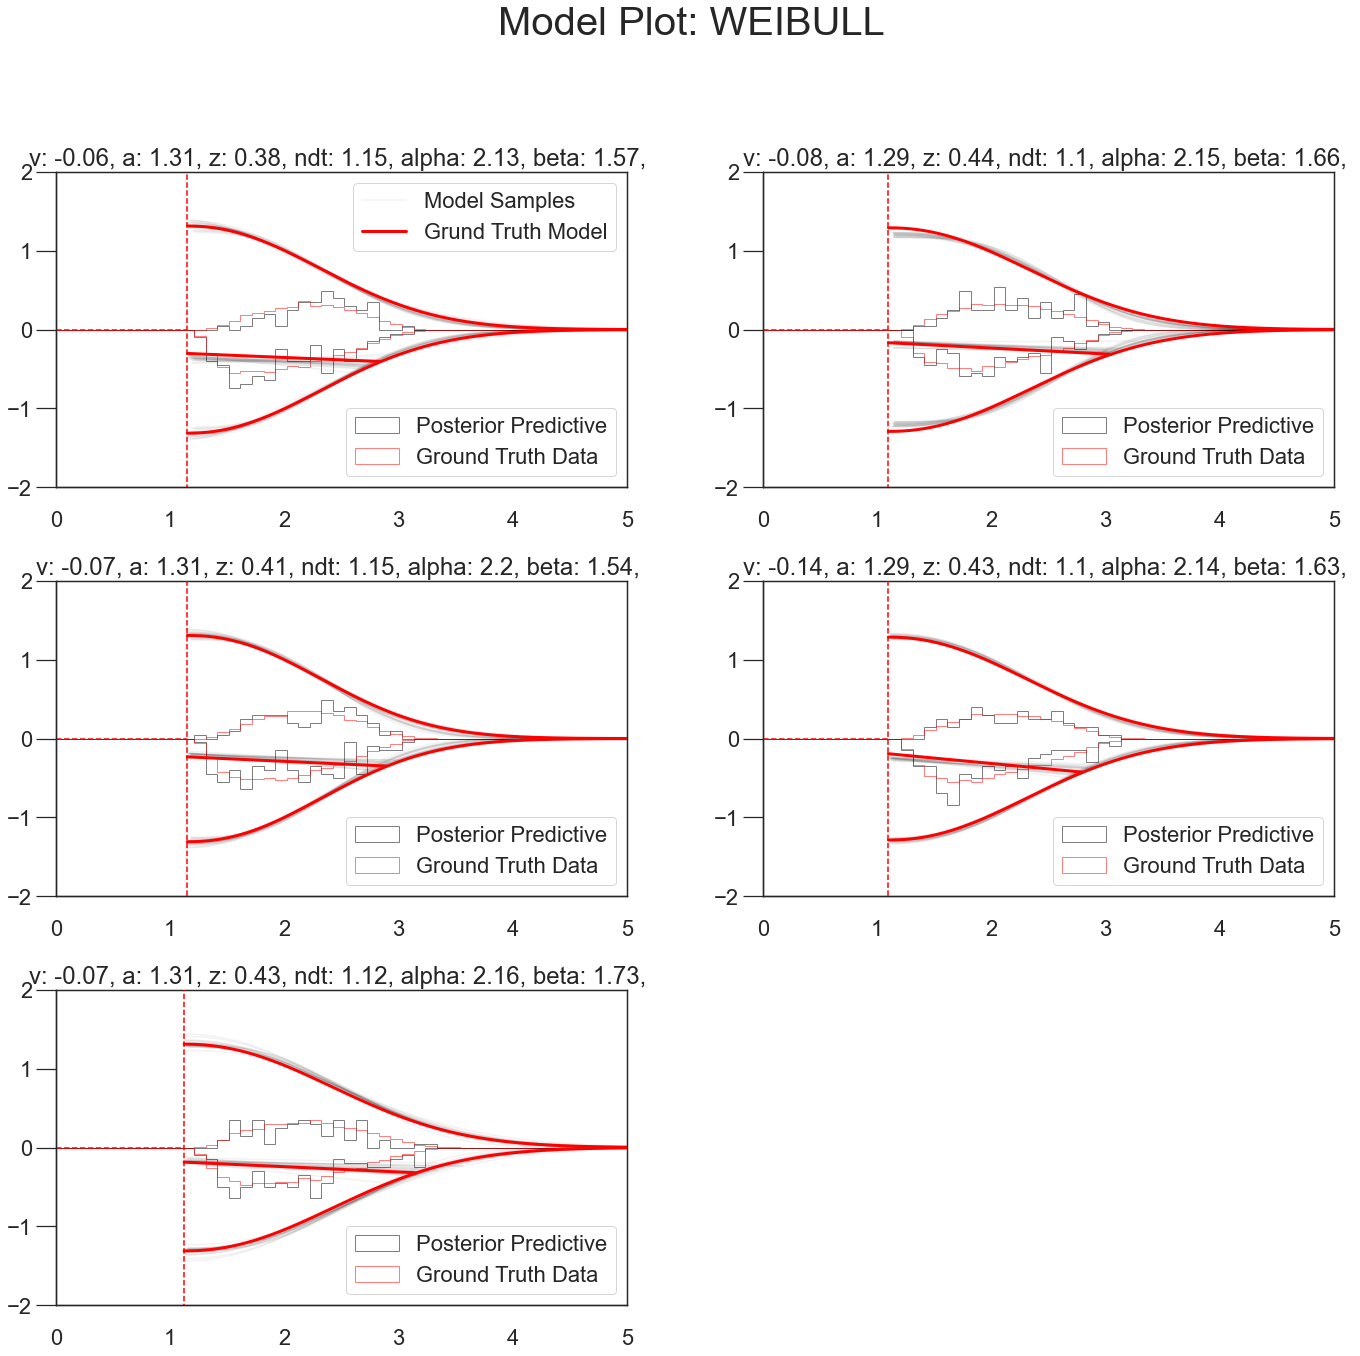

In [11]:
# Posterior Predictive
model_plot(ground_truths = hddm_data_hierarchical_weibull_cdf[1].values,
           posterior_samples = hddm_hierarchical_model_weibull_cdf.get_traces(),
           input_hddm_trace = True,
           n_post_params = 20,
           cols = 2, 
           model_gt = 'weibull_cdf',
           model_posterior = 'weibull_cdf',
           datatype = 'hierarchical',
           n_plots = 5,
           max_t = 5,
           show_model = True)

In [ ]:
# SECTION 4: PARAMETER VARIES BY CONDITION

In [ ]:
# An important aspect of these posterior analysis, is the consideration of experiment design.
# We may have an experiment in which subject are exposed to a variety of conditions, 
# such as for example different degrees of difficulty of the same task

# It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions

# As we will see, this can have important effects on the degree to which we will be able to recover 
# parameters from the data.

In [ ]:
# TODO: GIVE WRITTEN EXPLANATION OF ONE SUCH EXPERIMENTAL SETTING

In [100]:
# TODO: FIND CASE IN WHICH RECOVERY GETS BETTER BY INTRODUCING CONDITIONS

In [25]:
# Generating some data
# We generate data such that only one parameter varies by condition (in this case 'v' --> the slope)
hddm_data_condition, gt_condition, gt_mat_condition = simulator_condition_effects(n_conditions = 4, 
                                                                                  n_samples_by_condition = 1000,
                                                                                  condition_effect_on_param = ['z'], 
                                                                                  model = 'weibull_cdf',
                                                                                  )

2
[-2, 0.5, 0.3, 0.2, 1.0, 1.0]
2
[-2, 0.5, 0.3, 0.2, 1.0, 1.0]
2
[-2, 0.5, 0.3, 0.2, 1.0, 1.0]
2
[-2, 0.5, 0.3, 0.2, 1.0, 1.0]


In [26]:
hddm_data_condition

,rt,response,nn_response,condition
0,0.635545,0.0,-1,0
1,1.415535,1.0,1,0
2,1.163539,1.0,1,0
3,0.795543,0.0,-1,0
4,1.696548,1.0,1,0
...,...,...,...,...
995,1.841555,1.0,1,3
996,0.770544,1.0,1,3
997,2.025563,0.0,-1,3
998,1.333537,1.0,1,3


In [27]:
gt_condition

{'z(0)': 0.36291119246581105,
 'z(1)': 0.5933758147875352,
 'z(2)': 0.30773670403877496,
 'z(3)': 0.6349762777208185,
 'v': 0.9133597467987338,
 'a': 1.0006151229173272,
 't': 0.42754458172923776,
 'alpha': 1.3864792497336822,
 'beta': 5.672869501159375}

In [28]:
hddm_model_condition = hddm.HDDMnn_weibull(hddm_data_condition, 
                                           informative = False, 
                                           free = False, 
                                           k = True,
                                           include = ['z'],
                                           is_group_model = False, 
                                           depends_on = {'z': 'condition'})

In [59]:
hddm_model_condition_angle = hddm.HDDMnn_angle(hddm_data_condition, 
                                               informative = False, 
                                               free = False, 
                                               #k = True,
                                               include = ['z'],
                                               is_group_model = False, 
                                               depends_on = {'z': 'condition'})

In [60]:
ncmcm  = 200
hddm_model_condition_angle.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 200 of 200 complete in 87.3 sec

In [63]:
hddm_model_condition_angle.print_stats()

           mean         std       2.5q        25q       50q       75q     97.5q       mc err
a      0.986316   0.0102197   0.960604   0.982742  0.987383  0.992932    1.0061   0.00102197
v      0.972848   0.0257871   0.913676   0.956829  0.972724  0.989649   1.02528   0.00257871
t      0.443029  0.00456133   0.435692   0.440095  0.442673  0.445701  0.452371  0.000456133
z(0)   0.378918  0.00919554   0.363168   0.371992  0.378867  0.386398  0.395685  0.000919554
z(1)   0.581654  0.00976902   0.561866   0.575269  0.582732  0.588006  0.600988  0.000976902
z(2)   0.289672  0.00817366   0.273938   0.284604   0.28884  0.295422  0.308193  0.000817366
z(3)   0.622926   0.0104321   0.604379   0.615815  0.623203  0.628797  0.645082   0.00104321
theta  0.101185   0.0121725  0.0753394  0.0955729  0.101428  0.107992  0.128274   0.00121725
DIC: 6816.440298
deviance: 6808.662776
pD: 7.777522


In [29]:
nmcmc = 200
hddm_model_condition.sample(nmcmc, burn = 100)

 [-----------------100%-----------------] 201 of 200 complete in 106.1 sec

In [30]:
hddm_model_condition.print_stats()

           mean         std      2.5q       25q       50q       75q     97.5q       mc err
a      0.941738  0.00870369  0.926151  0.935468  0.941469  0.945543  0.962815  0.000870369
v      0.976304   0.0252481  0.935123  0.957874  0.974404  0.994967    1.0296   0.00252481
t      0.452238  0.00425386   0.43994  0.450089  0.452356  0.454847  0.459066  0.000425386
z(0)   0.381424  0.00684334  0.367642  0.377016  0.381522  0.386589  0.394644  0.000684334
z(1)   0.591338   0.0113967  0.569724  0.583611  0.589975  0.599852  0.613226   0.00113967
z(2)   0.286599  0.00746371  0.271953  0.281888  0.285842  0.291825  0.300669  0.000746371
z(3)   0.632217  0.00873473  0.613582  0.625751  0.632489  0.639474  0.646969  0.000873473
beta    3.34072    0.220113   3.04315   3.16868   3.30839     3.497   3.90406    0.0220113
alpha   2.75561    0.200508   2.40229     2.599   2.75458   2.89478   3.16031    0.0200508
DIC: 6797.951885
deviance: 6789.734976
pD: 8.216909


In [17]:
hddm_model_condition.get_traces()

,a,v,t,z_trans(0),z_trans(1),z_trans(2),z_trans(3),beta,alpha
0,1.257665,-1.033919,0.673344,-0.918399,0.626218,0.258176,0.037191,6.743306,4.758858
1,1.267646,-1.023697,0.680478,-0.928448,0.656194,0.289291,-0.015104,6.646755,4.747056
2,1.266798,-1.050341,0.676445,-0.923886,0.619299,0.315368,-0.017877,6.701047,4.897890
3,1.261486,-1.056464,0.676952,-0.955281,0.652096,0.296695,0.004346,6.713837,4.947364
4,1.240397,-1.017502,0.688083,-0.967119,0.614586,0.312419,-0.043453,6.779348,4.889494
...,...,...,...,...,...,...,...,...,...
95,1.286133,-1.068794,0.672573,-0.904931,0.745555,0.261351,-0.082406,6.407134,4.981636
96,1.279107,-1.023576,0.670029,-0.903503,0.645515,0.257649,-0.082494,6.722080,4.989304
97,1.279714,-1.032290,0.674033,-0.918872,0.675937,0.266706,-0.055845,6.860619,4.998826
98,1.274350,-1.058835,0.673261,-0.907885,0.695725,0.232328,-0.008875,6.795641,4.998867


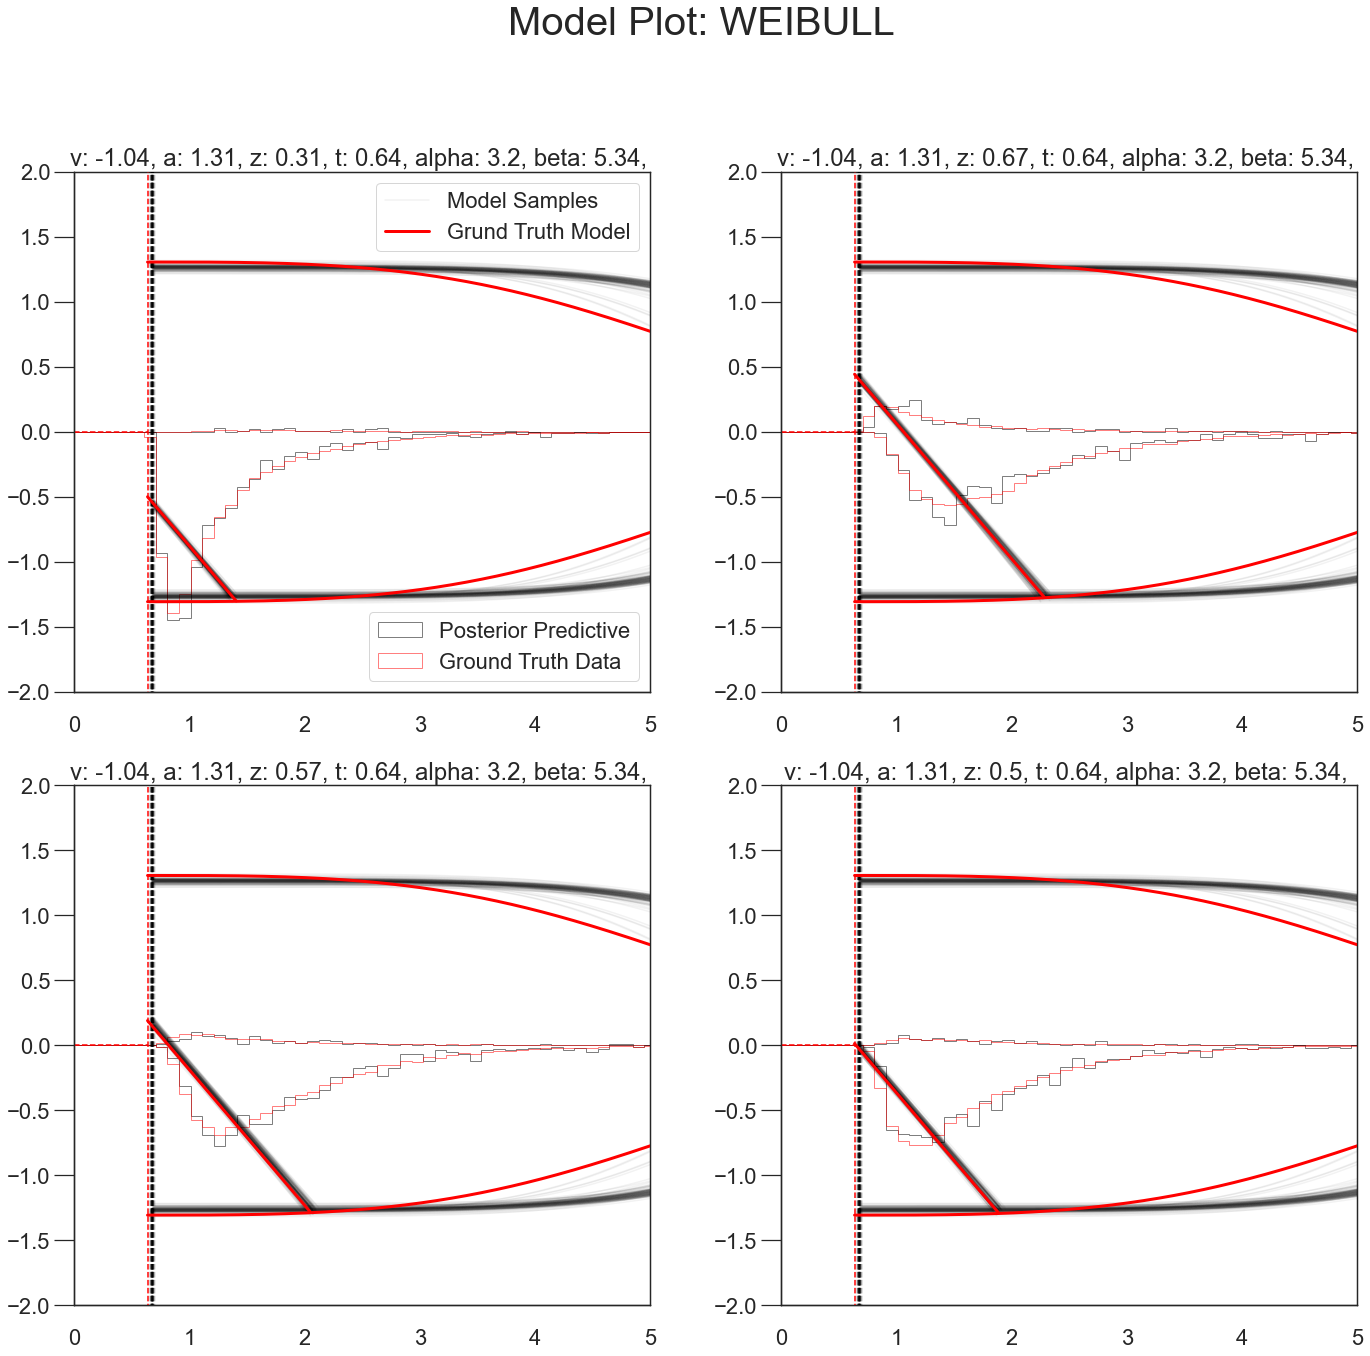

In [20]:
model_plot(posterior_samples = hddm_model_condition.get_traces(),
           ground_truths = gt_mat_condition,
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           datatype = 'condition',
           input_hddm_trace = True,
           n_post_params = 100,
           n_plots = 1,
           cols = 2,
           show_model = True)

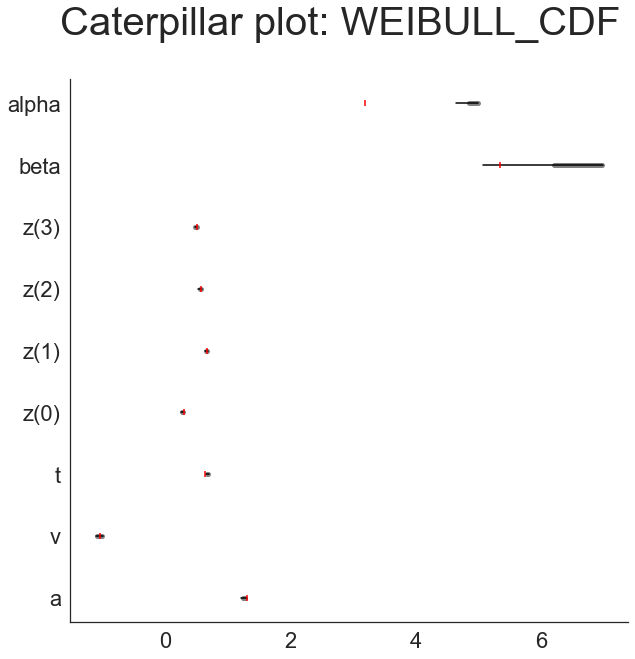

In [19]:
caterpillar_plot(posterior_samples = hddm_model_condition.get_traces(),
                 ground_truths = gt_condition,
                 model = 'weibull_cdf',
                 datatype = 'condition',
                 drop_sd = True)

In [71]:
# SECTION 5: MODEL RECOVERY 


In [52]:
# Let's generate data from one of our three models
weibull_params = make_parameter_sets(model = 'weibull_cdf',
                                     n_parameter_sets = 1)

simulations = simulator(theta = weibull_params.values[0],
                        model = 'weibull_cdf', 
                        n_samples = 1000)

hddm_data_single_subject_weibull = hddm_preprocess(simulations)

In [53]:
# Now we fit for each model:
hddm_model_single_subject_weibull = hddm.HDDMnn_weibull(hddm_data_single_subject_weibull, 
                                                informative = False, 
                                                free = False, 
                                                k = True,
                                                include = ['z'],
                                                is_group_model = False)

In [54]:
nmcmc = 500
hddm_model_single_subject_weibull.sample(nmcmc, 
                                         burn = 200)

 [-----------------100%-----------------] 500 of 500 complete in 70.1 sec

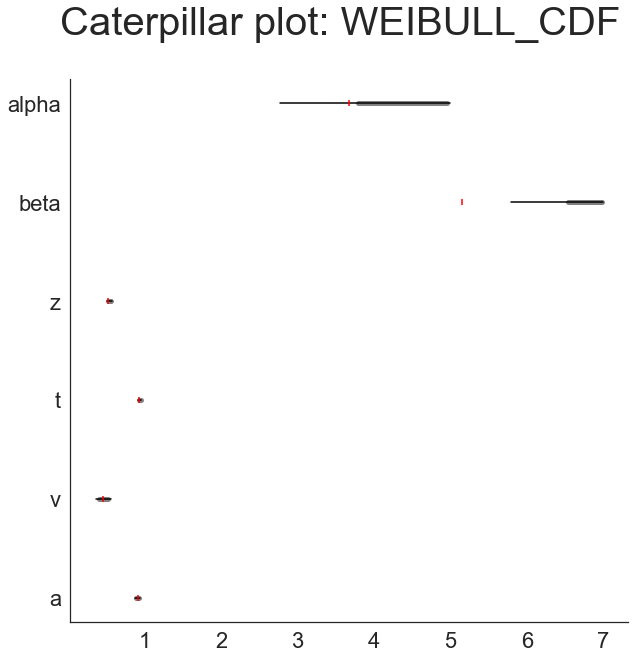

In [55]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_single_subject_weibull.get_traces(),
                 ground_truths = weibull_params.values[0],
                 model = 'weibull_cdf',
                 datatype = 'single_subject',
                 drop_sd = True)

passed through legend part
0
0


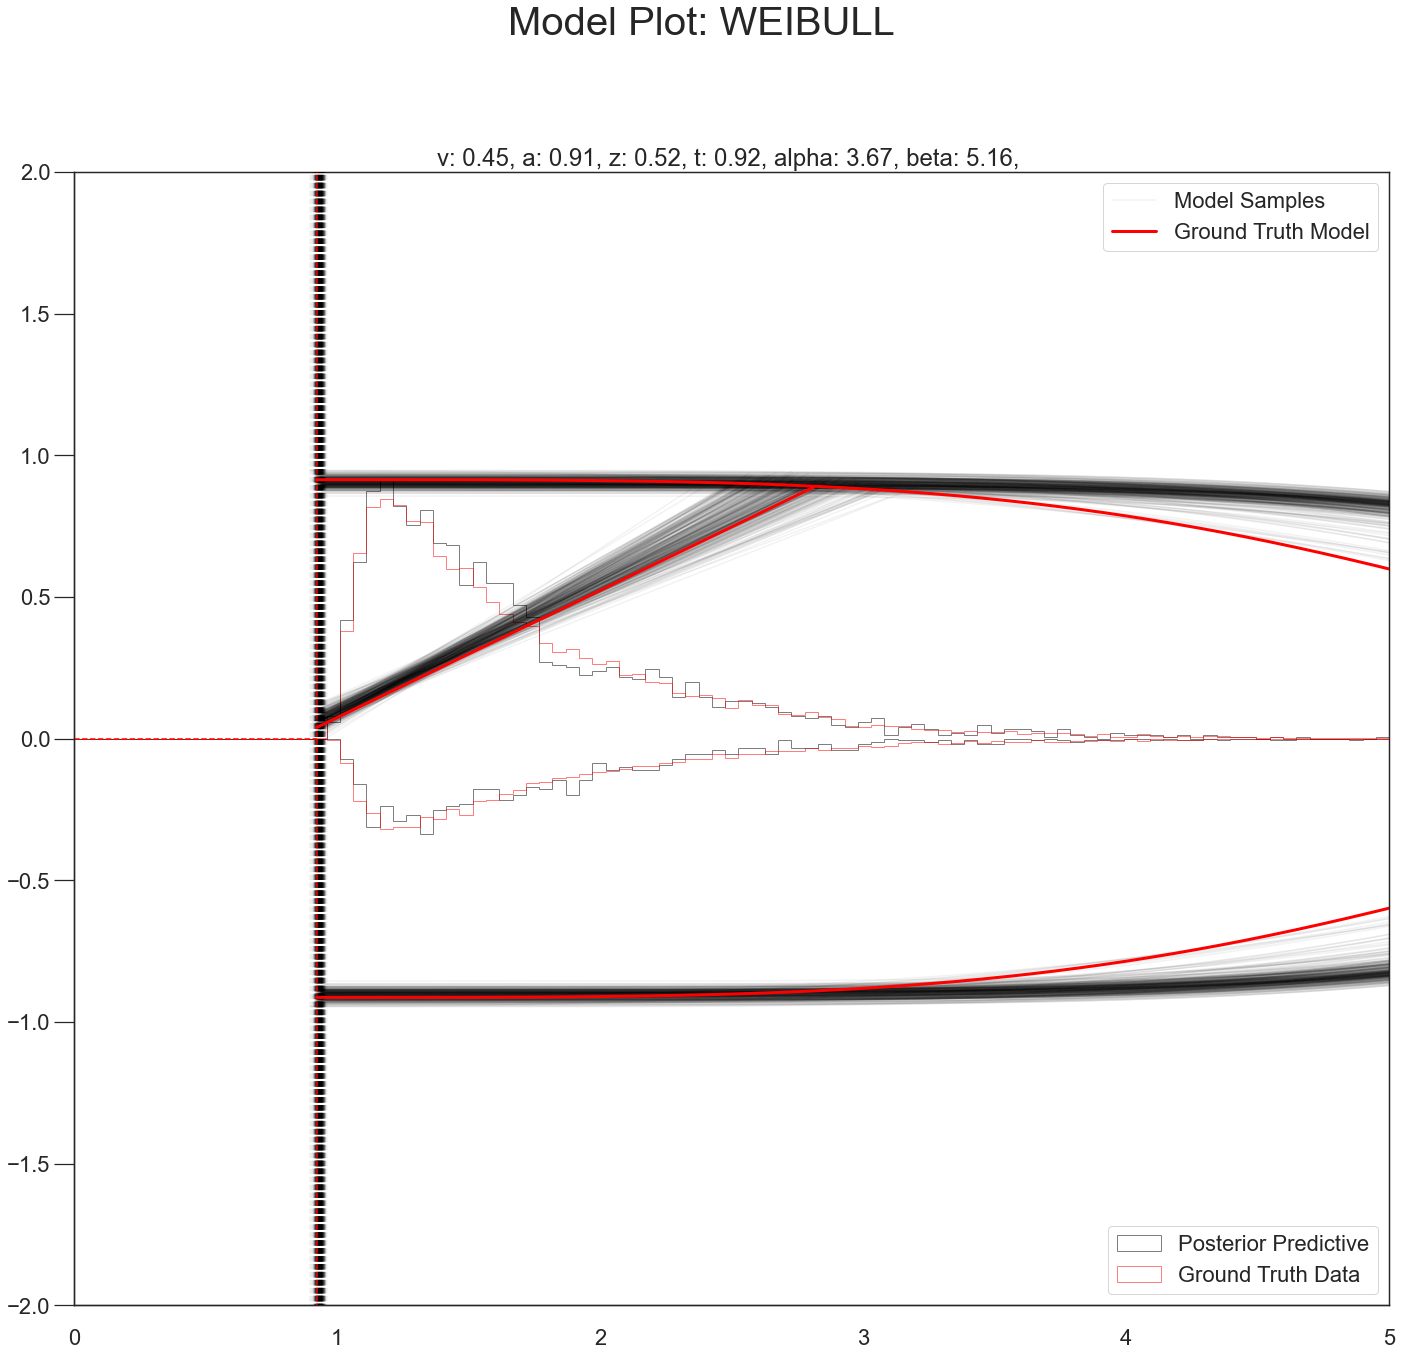

In [56]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_weibull.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'weibull_cdf',
           n_post_params = 300,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

In [57]:
# Now we fit for each model:
hddm_model_single_subject_angle = hddm.HDDMnn_angle(hddm_data_single_subject_weibull, 
                                                    informative = False, 
                                                    free = False,
                                                    include = ['z'],
                                                    is_group_model = False)

In [58]:
nmcmc = 500
hddm_model_single_subject_angle.sample(nmcmc, 
                                       burn = 200)

 [-----------------100%-----------------] 500 of 500 complete in 57.1 sec

In [59]:
hddm_model_single_subject_angle.get_traces().mean()

a          0.929239
v          0.476164
t          0.926250
z_trans    0.129526
theta      0.017111
dtype: float64

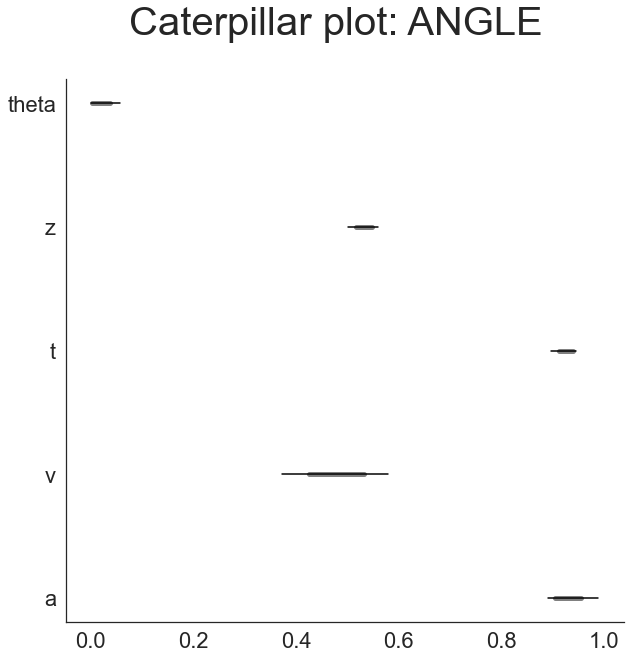

In [60]:
# Caterpillar Plot: (Parameters recovered ok?)
caterpillar_plot(posterior_samples = hddm_model_single_subject_angle.get_traces(),
                 ground_truths = None, #ground_truths = weibull_params.values[0],
                 model = 'angle',
                 datatype = 'single_subject',
                 drop_sd = True)

passed through legend part
0
0


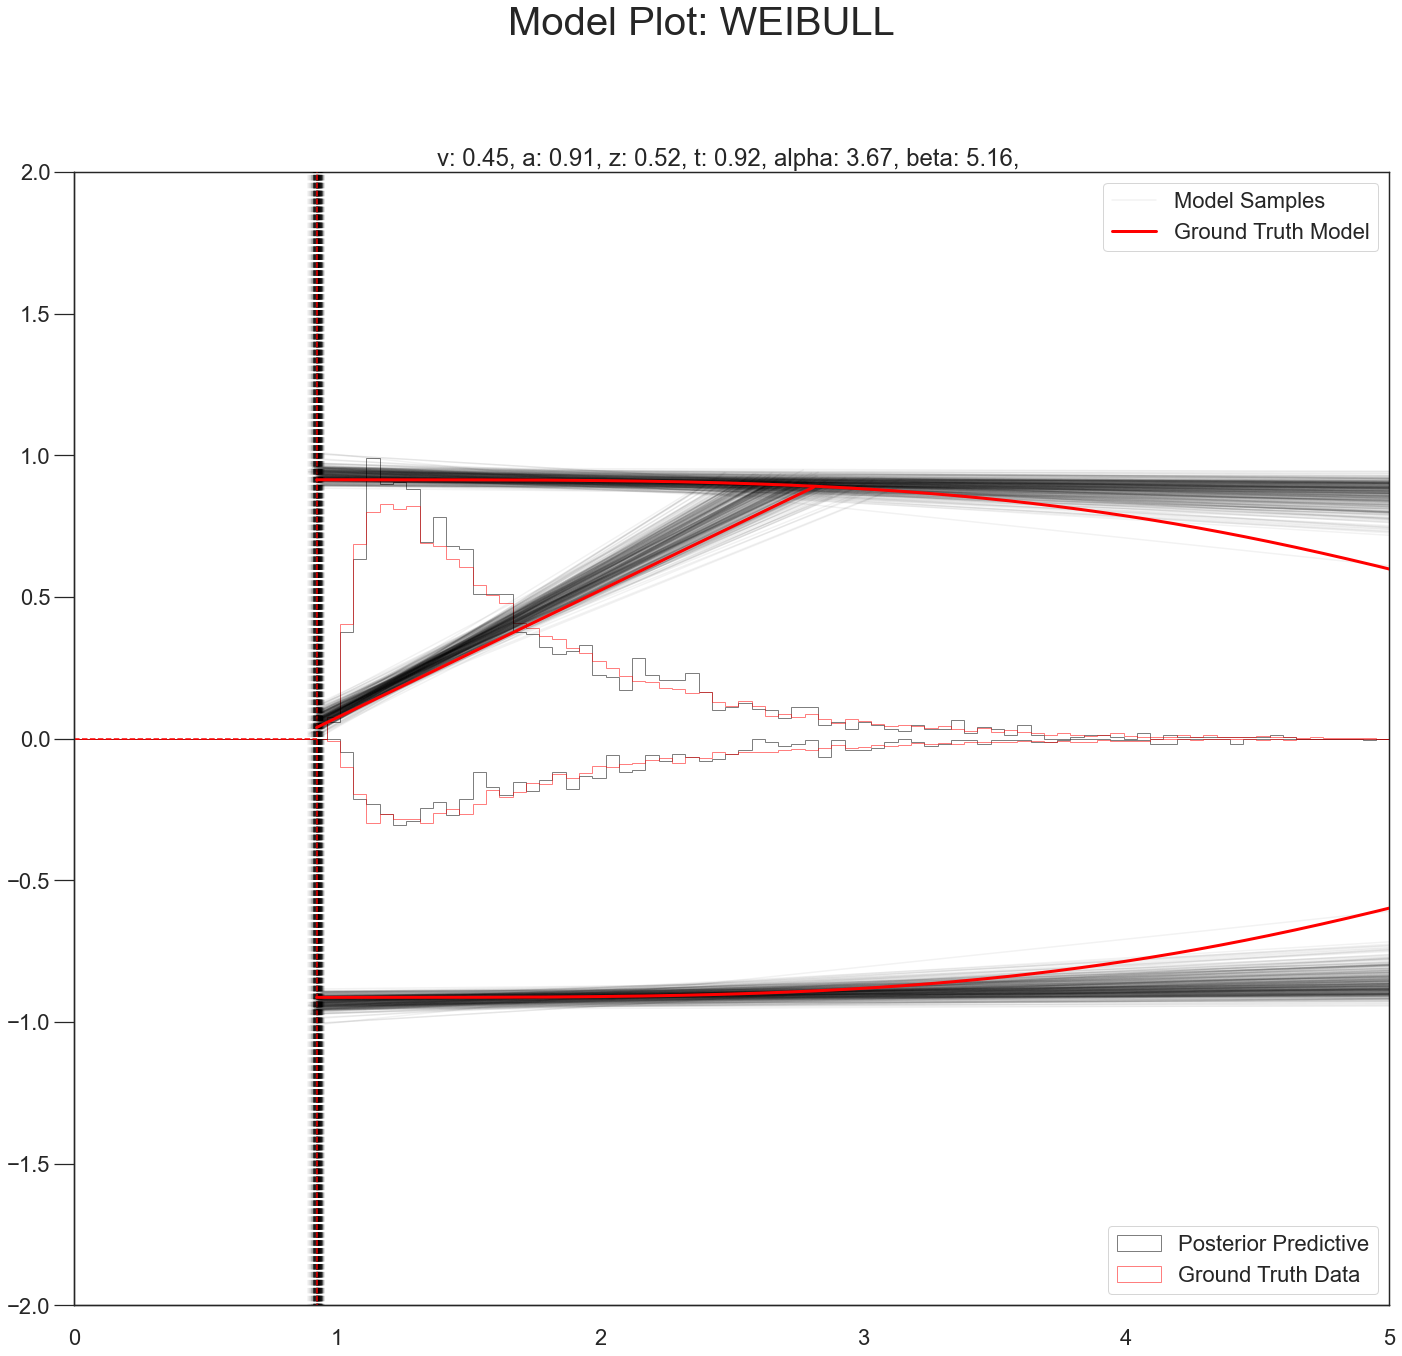

In [61]:
# Posterior Predictive: Do the 'Posterior Models' also make sense?
model_plot(ground_truths = weibull_params.values[0],
           posterior_samples = hddm_model_single_subject_angle.get_traces(),
           model_gt = 'weibull_cdf',
           model_fitted = 'angle',
           n_post_params = 300,
           cols = 1,
           n_plots = 1,
           max_t = 5,
           show_model = True,
           input_hddm_trace = True,
           datatype = 'single_subject')

In [64]:
# Let's compare the DIC's 

In [62]:
hddm_model_single_subject_angle.dic

2529.0182031249997

In [63]:
hddm_model_single_subject_weibull.dic

2536.051516927083